# Classificação da dificuldade/facilidade de questões de programação

Este notebook apresenta a parte I de um Projeto de Iniciação Científica (PIBIC) desenvolvido na Universidade Federal do Amazonas (UFAM) pelo discente Marcos A. P. de Lima, sob orientação do Prof. Dr. Leandro S. G. de Carvalho.

Esse projeto almeja classificar a dificuldade/facilidade de novas questões de programação de um ambiente de correção automática de código (ACACs) utilizado pela instituição, o [Codebench](http://codebench.icomp.ufam.edu.br/). A classificação da dificuldade/faciidade é um problema recorrente em ACACs devido suas amplas possibilidades de aplicação.

Uma vez que a base de questões tenha sido classificada é possível sugerir, para um estudante, o grupo de questões mais adequadas para nível de conhecimento atual. Além disso, a classificação das questões auxilia o instrutor (professor ou monitor) da disciplina a confeccionar atividades (trabalhos ou provas) de forma equilibrada.

Neste trabalho um grupo de 354 questões foi classificado segundo sua facilidade ("fácil" ou "não fácil") por meio de atributos extraídos tanto de códigos de solução (modelos de solução) elaborados pelos instrutores quanto de atributos extraídos dos enunciados das questões. Esse grupo de questões foi utilizado em exames presenciais da disciplina de Introdução à Programação de Computadores (IPC) entre os anos de 2017 e 2019.

Neste notebook será apresentado a análise e processamentos dos dados. No notebook 2 será apresentado o modelo de classificação proposto.

Lista de artigos publicados:

- LIMA, Marcos; CARVALHO, Leandro Silva Galvão de; OLIVEIRA, Elaine Harada Teixeira de; OLIVEIRA, David Braga Fernandes; PEREIRA, Filipe Dwan. [Classificação de dificuldade de questões de programação com base em métricas de código](https://doi.org/10.5753/cbie.sbie.2020.1323.). In: SIMPÓSIO BRASILEIRO DE INFORMÁTICA NA EDUCAÇÃO, 31. , 2020, Online. Anais. Porto Alegre: Sociedade Brasileira de Computação, 2020 . p. 1323-1332.
- LIMA, Marcos; CARVALHO, Leandro Silva Galvão de; OLIVEIRA, Elaine Harada Teixeira de; OLIVEIRA, David Braga Fernandes; PEREIRA, Filipe Dwan. Uso de atributos de código para classificação da facilidade de questões de codificação. In: SIMPÓSIO BRASILEIRO DE EDUCAÇÃO EM COMPUTAÇÃO, 2021, Online. Anais. Porto Alegre: Sociedade Brasileira de Computação, 2021 . p. xxx. DOI: ...





## 1 - Módulos Necessários

Abaixo estãos os módulos utilizados para análise e processamento dos dados extraídos do dataset pelo uso do [Codebench Extractor](https://github.com/marcosmapl/codebench-extractor).

In [1]:
import pandas as pd # análise de dados tabulares em dataframes
import numpy as np # computação numérica
from scipy import stats # computo de z-score para detecção de outliers

# quantidade de colunas e linhas ilimitadas
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# construção de gráficos para visualização dos dados
import matplotlib as mpl
import matplotlib.pyplot as plt

default_figsize = (18, 10)
plt.style.use('seaborn-ticks') # define o tema 'seaborn-dark' como padrão para os gráficos gerados com matplotlib
plt.rcParams["figure.figsize"] = default_figsize # define o tamanho padrão dos gráficos
# apresenta os gráficos abaixo do código além de incluí-los no notebook
%matplotlib inline

# construção de gráficos para visualização dos dados
import seaborn as sns
sns.set(style="ticks")
sns.set(rc={'figure.figsize':default_figsize})

# expressões regulares
import re

# ignora 'warnings'
import warnings
warnings.filterwarnings('ignore')

show_base_fig = False
show_meta_fig = False

As versões utilizadas de cada módulo podem ser conferidas abaixo:

In [2]:
print(f'Pandas v{pd.__version__}')
print(f'Numpy v{np.__version__}')
print(f'Matplotlib v{mpl.__version__}')
print(f'Seaborn v{sns.__version__}')

Pandas v1.1.5
Numpy v1.19.5
Matplotlib v3.2.2
Seaborn v0.11.1


## 2 - Dataset de soluções dos instrutores

O arquivo `solucoes.csv`, gerado pelo extrator, armazena as informações extraídas dos códigos-fonte de solução propostos por instrutores para as questões do Codebench.

Os atributos extraídos dos arquivos de código-fonte contidos no dataset são descritos abaixo:

- `codigo`: Código numérico único que identifica o __exercício__ (questão de codificação).
- `complexity`: __Complexidade ciclomática__ (McCabe’s Cyclomatic complexity, 1976) total.
- `n_classes`: Número de __classes__ implementadas pelo instrutor no código-fonte.
- `n_functions`: Número de __funções__ implementadas pelo instrutor no código-fonte.
- `loc`: Número total de __linhas de código__.
- `lloc`: Número total de __linhas lógicas de código__.
- `sloc`: Número de linhas de __código fonte__.
- `single_comments`: Número de __comentários__.
- `comments`: Número de linhas de __docstrings__ (comentários de documentação).
- `multilines`: Número de __multi-line strings__.
- `black_lines`: Número de __linhas em branco__.
- Métricas de Software (Halstead Complexity Metrics, 1977):
    - `h1`: Número de __operadores distintos__.
    - `h2`: Número de __operandos distintos__.
    - `N1`: Número __total de operadores__.
    - `N2`: Número __total de operandos__.
    - `vocabulary`: __vocabulário__ (`h = h1 + h2`).
    - `length`: __Tamanho estimado__ estimado (`N = N1 + N2`).
    - `calculated_N`: __Tamanho estimado__ em bytes (`h1*log2(h1) + h2*log2(h2)`).
    - `volume`: __Volume__ (`V = N * log2(h)`).
    - `difficulty`: __Dificuldade de entendimento__ (`D = h1/2 * N2/h2`).
    - `effort`: __Esforço de emplementação__ (`E = D * V`).
    - `time`: __Tempo estimado de emplementação__ (`T = E / 18 segundos`).
    - `bugs`: Quantidade estimada de __bugs/erros__ na implementação (`B = V / 3000`).
- Tokens (obtidos do código fonte com uso dos módulos Radon e Tokenize, para a linguagem Python):
    - `imports`: Quantidade de __linhas de importação__
    - `assignments` Quantidade total de __operações de atribuição__ (incluindo atribuição combinada com outros operadores)
    - `assignments_unique`: Quantidade de __operadores de atribuição distintos__
    - `kwds`: Quantidade total de __keywords__
    - `kwds_unique`: Quantidade de __keywords distintas__
    - `lt_numbers`: Quantidade de __constantes numéricas__
    - `lt_strs`: Quantidade de __constantes de texto (strings)__
    - `lt_bools`: Quantidade de __constantes booleanas__
    - `lgc_op`: Quantidade total de __operadores lógicos__
    - `lgc_op_unique`: Quantidade de __operadores lógicos distintos__
    - `and_op`: Quantidade total de __operadores lógicos 'and'__
    - `or_op`: Quantidade total de __operadores lógicos 'or'__
    - `not_op`: Quantidade total de __operadores lógicos 'not'__
    - `arithmetic_op`: Quantidade total de __operadores aritméticos__
    - `arithmetic_op_unique`: Quantidade de __operadores aritméticos distintos__
    - `add_op`: Quantidade total de __operadores de adição '+'__
    - `minus_op`: Quantidade total de __operadores de substração '-'__
    - `mult_op`: Quantidade total de __operadores de multiplicação '*'__
    - `div_op`: Quantidade total de __operadores de divisão ponto-flutuante '/'__
    - `mod_op`: Quantidade total de __operadores módulo '%'__
    - `power_op`: Quantidade total de __operadores potência '**'__
    - `div_floor_op`: Quantidade total de __operadores de divisão inteira '//'__
    - `cmp_op`: Quantidade total de __operadores relacionais__
    - `cmp_op_unique`: Quantidade de __operadores relacionais distintos__
    - `equal_op`: Quantidade total de __operadores de igualdade '=='__
    - `not_eq_op`: Quantidade total de __operadores de desigualdade '!='__
    - `le_op`: Quantidade total de __operadores menor ou igual que '<='__
    - `ge_equal_op`: Quantidade total de __operadores maior ou igual que '>='__
    - `lt_op`: Quantidade total de __operadores menor que '<'__
    - `gt_op`: Quantidade total de __operadores maior que '>'__
    - `bitwise_op`: Quantidade total de __operadores bit-a-bit__
    - `bitwise_op_unique`: Quantidade de __operadores bit-a-bit distintos__
    - `bitwise_and`: Quantidade total de __operadores bit-a-bit and '&'__
    - `bitwise_or`: Quantidade total de __operadores bit-a-bit or '|'__
    - `bitwise_xor`: Quantidade total de __operadores bit-a-bit xor '^'__
    - `bitwise_not`: Quantidade total de __operadores bit-a-bit not (comp) '~'__
    - `lshift_op`: Quantidade total de __operadores left shift '<<'__
    - `rshift_op`: Quantidade total de __operadores de right shift '>>'__
    - `identity_op`: Quantidade total de __operadores is__
    - `membership_op`: Quantidade total de __operadores in__
    - `conditionals`: Quantidade total de __estruturas condicionais__ (if, elif, else)
    - `ifs`: Quantidade total de operadores __if__
    - `elifs`: Quantidade total de operadores __elif__
    - `elses`: Quantidade total de operadores __else__
    - `loops`: Quantidade total de operadores __estruturas de repetição__ (while, for)
    - `whiles`: Quantidade total de operadores __while__
    - `fors`: Quantidade total de operadores __for__
    - `breaks`: Quantidade de operadores __break__
    - `continues`: Quantidade de operadores __continue__
    - `builtin_f`: Quantidade total de __built-in functions__
    - `builtin_f_unique`: Quantidade de __built-in functions__ distintas
    - `type_f`: Quantidade total de funções de __casting/tipo__ (list, tuple, str, int, float ...)
    - `type_f_unique`: Quantidade de funções de __casting/tipo distintas__
    - `lambdas`: Quantidade de __expressões lambda__
    - `lpar`: Quantidade total de __(__
    - `rpar`: Quantidade total de __)__
    - `lsqb`: Quantidade total de __[__
    - `rsqb`: Quantidade total de __]__
    - `lbrace`: Quantidade total de __{__
    - `rbrace`: Quantidade total de __}__
    - `commas`: Quantidade total de __,__
    - `colons`: Quantidade total de __:__
    - `dots`: Quantidade total de __.__
    - `prints`: Quantidade total de funções __print (saídas)__
    - `inputs`: Quantidade total de funçõe __input (entradas)__
    - `len`: Quantidade total de funções __len (tamanho de sequences)__
    - `uident`: Quantidade total de __identificadores definidos pelo instrutor__
    - `uident_unique`: Quantidade de __identificadores distintos definidos pelo instrutor__
    - `uident_mean`: Proporção entre __identificadores distintos__ e o total de __identificadores__ definidos pelo instrutor no código
    - `uident_per_line`: Proporção entre __identificadores__ definidos pelo instrutor e __linhas de código (loc)__, (__quantidade de linhas de código com identifiers__)
    - `uident_chars`: Média de __caracteres (letras)__ nos __identificadores__

In [3]:
solucoes = pd.read_csv(
    'https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/solucoes.csv'
)
solucoes.name = 'Dataframe Soluções dos Instrutores'
solucoes.head()

,codigo,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,2455,3,0,0,12,10,10,0,0,0,2,2,7,5,10,9,15,21.651484,47.548875,1.428571,67.926964,0.015850,3.773720,0,5,1,4,2,6,2,0,0,0,0,0,0,3,1,0,0,3,0,0,0,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,2,0,0,0,0,0,6,5,2,2,0,8,8,0,0,0,0,1,4,0,1,2,0,11,3,1.375000,0.846154,5.666667
1,1053,2,0,0,8,6,6,0,0,0,2,2,3,2,4,5,6,6.754888,13.931569,1.333333,18.575425,0.004644,1.031968,0,3,1,2,2,0,3,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,0,0,2,2,0,0,0,2,2,0,0,0,0,0,2,0,1,1,0,6,2,1.200000,0.666667,7.500000
2,1014,1,0,0,12,4,3,0,0,5,4,1,2,1,2,3,3,2.000000,4.754888,0.500000,2.377444,0.001585,0.132080,0,2,1,0,0,2,2,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,1,1,0,4,4,0,0,0,0,1,0,0,1,1,0,4,2,1.333333,0.307692,5.500000
3,3031,6,0,0,19,11,10,0,0,5,4,4,8,9,18,12,27,32.000000,96.793988,4.500000,435.572944,0.032265,24.198497,0,5,1,6,4,10,2,0,2,1,2,0,0,2,1,0,0,0,0,0,2,0,5,2,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,4,1,2,1,0,0,0,0,0,4,4,1,1,0,7,7,0,0,0,0,1,4,0,1,1,0,13,2,1.444444,0.650000,1.500000
4,2461,6,0,0,23,11,10,2,2,8,3,4,12,11,22,16,33,51.019550,132.000000,3.666667,484.000000,0.044000,26.888889,0,5,1,6,4,10,2,0,2,1,2,0,0,4,1,0,0,4,0,0,0,0,5,2,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,4,1,2,1,0,0,0,0,0,4,4,1,1,0,7,7,0,0,0,0,1,4,0,1,1,0,15,2,1.666667,0.625000,7.500000


In [4]:
solucoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 94 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   codigo                660 non-null    int64  
 1   complexity            660 non-null    int64  
 2   n_classes             660 non-null    int64  
 3   n_functions           660 non-null    int64  
 4   loc                   660 non-null    int64  
 5   lloc                  660 non-null    int64  
 6   sloc                  660 non-null    int64  
 7   single_comments       660 non-null    int64  
 8   comments              660 non-null    int64  
 9   multilines            660 non-null    int64  
 10  blank_lines           660 non-null    int64  
 11  h1                    660 non-null    int64  
 12  h2                    660 non-null    int64  
 13  N1                    660 non-null    int64  
 14  N2                    660 non-null    int64  
 15  h                     6

Observando as informações do dataframe temos 660 observações (soluções de questões) e 94 atributos para cada observação.

Não existem valores faltantes (missing-values).



Os códigos dos execícios são únicos, isto é, cada observação traz atributos extraídos de um código de solução para uma questão distinta.

In [5]:
codigos_questoes = solucoes.codigo.unique()
codigos_questoes.shape

(660,)

## 3 - Dataset de Atividades

O arquivo `atividades.csv`, gerado pelo extrator, armazena informações das __Atividades__ ocorridas em __Turmas__ da disciplina de IPC.

Os atributos extraídos dos arquivos de log contidos no dataset são descritos abaixo:

- `periodo`: Descrição do período (ano e número do semestre) no qual a atividade ocorreu.
- `turma`: Código da turma (Disciplina).
- `codigo`: Código numérico único que identifica a atividade.
- `titulo`: Título (descrição) da atividade.
- `data_inicio`: Data de início da atividade. Formato `yyyy-mm-dd hh:mm`.
- `data_termino`: Data de término da atividade. Formato `yyyy-mm-dd hh:mm`.
- `linguagem`: Linguagem de programação que deverá ser utilizada para implementar as soluções das questões de programação selecionadas para a atividade.
- `tipo`: Tipo da atividade (`exam` ou `homework`).
- `peso`: Peso (contribuição) da nota da atividade na nota final da disciplina.
- `n_blocos`: Números de blocos de questões. Cada bloco é uma `lista` contendo o código de um ou mais questões. O sistema seleciona aleatoriamente questões de cada bloco para compor a atividade de cada estudante.
- `blocos`: Lista dos blocos de questões.

In [6]:
atividades = pd.read_csv(
    'https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/atividades.csv',
    index_col=False
)
atividades.name = 'Dataframe Atividades'
atividades.head()

,periodo,turma,codigo,titulo,data_inicio,data_termino,linguagem,tipo,peso,n_blocos,blocos
0,2019-2,264,1977,TP 01: Variáveis e Estrutura Sequencial (2019),2019-09-02 08:00,2019-09-02 09:50,Python 3,exam,1.0,3,"[[1027, 1028, 1029, 1030, 1031, 1032, 3309], [..."
1,2019-2,264,2028,Lab 3 – Estrutura Condicional Encadeada (2019),2019-09-18 08:00,2019-09-30 08:00,Python 3,homework,1.0,12,"[[1079, 1099], 1100, 1103, 1104, 1101, 1872, 1..."
2,2019-2,264,1994,Desafios 2 - Estruturas Condicionais (2019),2019-09-09 10:00,2019-12-09 08:00,Python 3,homework,1.0,8,"[2449, 652, 1092, 2971, 1879, 1418, 1397, 1395]"
3,2019-2,264,1906,Lab 0 – Primeiros passos com o Python - 2019,2019-08-12 08:00,2019-09-02 08:00,Python 3,homework,1.0,16,"[994, 996, 1326, 1327, 1328, 1329, 1330, 1331,..."
4,2019-2,264,1985,Lab 2 – Estrutura Condicional Simples (2019),2019-09-04 08:00,2019-09-16 07:59,Python 3,homework,1.0,12,"[2442, 3335, 1054, 2447, 869, 1053, 2445, 2969..."


In [7]:
atividades.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   periodo       907 non-null    object 
 1   turma         907 non-null    int64  
 2   codigo        907 non-null    int64  
 3   titulo        907 non-null    object 
 4   data_inicio   907 non-null    object 
 5   data_termino  907 non-null    object 
 6   linguagem     907 non-null    object 
 7   tipo          907 non-null    object 
 8   peso          907 non-null    float64
 9   n_blocos      907 non-null    int64  
 10  blocos        907 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 78.1+ KB


In [8]:
atividades.data_inicio.min(), atividades.data_inicio.max()

('2017-03-13 00:00', '2019-09-18 15:30')

Ao todo são 907 atividades ocorridas entre 13/03/2017 e 18/09/2019.

Só temos interesse nas atividades do tipo `exam`.

In [9]:
avaliacoes = atividades[atividades.tipo == 'exam']
avaliacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 904
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   periodo       312 non-null    object 
 1   turma         312 non-null    int64  
 2   codigo        312 non-null    int64  
 3   titulo        312 non-null    object 
 4   data_inicio   312 non-null    object 
 5   data_termino  312 non-null    object 
 6   linguagem     312 non-null    object 
 7   tipo          312 non-null    object 
 8   peso          312 non-null    float64
 9   n_blocos      312 non-null    int64  
 10  blocos        312 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 29.2+ KB


## 3 - Dataset de Tentativas feitas pelos Estudantes.

O arquivo `execucoes.csv`, gerado pelo extrator, armazena informações das __Tentativas__ feitas pelos __Estudantes__.

Os atributos extraídos dos arquivos de log contidos no dataset são descritos abaixo:
- `periodo`: Descrição do Período (ano e número do semestre).
- `turma`: Código da Turma (Disciplina) em que o estudante estava matriculado.
- `estudante`: Código numérico único que identifica o estudante.
- `atividade`: Código numérico único que identifica a atividade.
- `exercicio`: Código numérico único que identifica o exercicio (questão de codificação).
- `tempo_foco`: Tempo em segundos em que o estudante interagiu com o editor do CodeMirror, desconsiderando os intervalos onde não houve interação com o editor por um período superior a 5 minutos (intervalos de inatividade).
- `tempo_total`: Tempo total em segundos em que o estudante interagiu com o editor do CodeMirror, dentro do intervalo de duração da atividade.
- `n_submissoes`: Quantidade de submissões para correção automática realizadas pelo estudante.
- `n_testes`: Quantidade execuções de código (testes) realizadas pelo estudante, sem submetê-lo para correção.
- `n_erros`: Quantidade erros acusados pelo interpretador Python durante submissões ou testes.
- `t_execucao`: Tempo em segundos que a solução do estudante levou para executar todos os casos de testes do exercício.
- `nota_final`: Maior nota obtida pelo estudante nas submissões.
- `acertou`: Booleano indicando se o estudante conseguiu solucionar o exercício.

Os atributos extraídos dos arquivos de códigos-fonte contidos no dataset são descritos abaixo:
- `n_classes`: Número de __Classes__ implementadas pelo estudante no código-fonte.
- `n_functions`: Número de __Funções__ implementadas pelo estudante no código-fonte.
- `loc`: Número total de __linhas de código__.
- `lloc`: Número total de __linhas lógicas de código__.
- `sloc`: Número de linhas de __código fonte__.
- `single_comments`: Número de __comentários__.
- `comments`: Número de linhas de __docstrings__ (comentários de documentação).
- `multilines`: Número de __multi-line strings__.
- `black_lines`: Número de __linhas em branco__.
- Métricas de Software (Halstead Complexity Metrics, 1977):
    - `h1`: Número de __operadores distintos__.
    - `h2`: Número de __operandos distintos__.
    - `N1`: Número __total de operadores__.
    - `N2`: Número __total de operandos__.
    - `vocabulary`: __vocabulário__ (`h = h1 + h2`).
    - `length`: __Tamanho estimado__ estimado (`N = N1 + N2`).
    - `calculated_N`: __Tamanho estimado__ em bytes (`h1*log2(h1) + h2*log2(h2)`).
    - `volume`: __Volume__ (`V = N * log2(h)`).
    - `difficulty`: __Dificuldade de entendimento__ (`D = h1/2 * N2/h2`).
    - `effort`: __Esforço de emplementação__ (`E = D * V`).
    - `time`: __Tempo estimado de emplementação__ (`T = E / 18 segundos`).
    - `bugs`: Quantidade estimada de __bugs/erros__ na implementação (`B = V / 3000`).
- Tokens (obtidos do código fonte com uso dos módulos Radon e Tokenize, para a linguagem Python):
    - `imports`: Quantidade de __linhas de importação__
    - `assignments` Quantidade total de __operações de atribuição__ (incluindo atribuição combinada com outros operadores)
    - `assignments_unique`: Quantidade de __operadores de atribuição distintos__
    - `kwds`: Quantidade total de __keywords__
    - `kwds_unique`: Quantidade de __keywords distintas__
    - `lt_numbers`: Quantidade de __constantes numéricas__
    - `lt_strs`: Quantidade de __constantes de texto (strings)__
    - `lt_bools`: Quantidade de __constantes booleanas__
    - `lgc_op`: Quantidade total de __operadores lógicos__
    - `lgc_op_unique`: Quantidade de __operadores lógicos distintos__
    - `and_op`: Quantidade total de __operadores lógicos 'and'__
    - `or_op`: Quantidade total de __operadores lógicos 'or'__
    - `not_op`: Quantidade total de __operadores lógicos 'not'__
    - `arithmetic_op`: Quantidade total de __operadores aritméticos__
    - `arithmetic_op_unique`: Quantidade de __operadores aritméticos distintos__
    - `add_op`: Quantidade total de __operadores de adição '+'__
    - `minus_op`: Quantidade total de __operadores de substração '-'__
    - `mult_op`: Quantidade total de __operadores de multiplicação '*'__
    - `div_op`: Quantidade total de __operadores de divisão ponto-flutuante '/'__
    - `mod_op`: Quantidade total de __operadores módulo '%'__
    - `power_op`: Quantidade total de __operadores potência '**'__
    - `div_floor_op`: Quantidade total de __operadores de divisão inteira '//'__
    - `cmp_op`: Quantidade total de __operadores relacionais__
    - `cmp_op_unique`: Quantidade de __operadores relacionais distintos__
    - `equal_op`: Quantidade total de __operadores de igualdade '=='__
    - `not_eq_op`: Quantidade total de __operadores de desigualdade '!='__
    - `le_op`: Quantidade total de __operadores menor ou igual que '<='__
    - `ge_equal_op`: Quantidade total de __operadores maior ou igual que '>='__
    - `lt_op`: Quantidade total de __operadores menor que '<'__
    - `gt_op`: Quantidade total de __operadores maior que '>'__
    - `bitwise_op`: Quantidade total de __operadores bit-a-bit__
    - `bitwise_op_unique`: Quantidade de __operadores bit-a-bit distintos__
    - `bitwise_and`: Quantidade total de __operadores bit-a-bit and '&'__
    - `bitwise_or`: Quantidade total de __operadores bit-a-bit or '|'__
    - `bitwise_xor`: Quantidade total de __operadores bit-a-bit xor '^'__
    - `bitwise_not`: Quantidade total de __operadores bit-a-bit not (comp) '~'__
    - `lshift_op`: Quantidade total de __operadores left shift '<<'__
    - `rshift_op`: Quantidade total de __operadores de right shift '>>'__
    - `identity_op`: Quantidade total de __operadores is__
    - `membership_op`: Quantidade total de __operadores in__
    - `conditionals`: Quantidade total de __estruturas condicionais__ (if, elif, else)
    - `ifs`: Quantidade total de operadores __if__
    - `elifs`: Quantidade total de operadores __elif__
    - `elses`: Quantidade total de operadores __else__
    - `loops`: Quantidade total de operadores __estruturas de repetição__ (while, for)
    - `whiles`: Quantidade total de operadores __while__
    - `fors`: Quantidade total de operadores __for__
    - `breaks`: Quantidade de operadores __break__
    - `continues`: Quantidade de operadores __continue__
    - `builtin_f`: Quantidade total de __built-in functions__
    - `builtin_f_unique`: Quantidade de __built-in functions__ distintas
    - `type_f`: Quantidade total de funções de __casting/tipo__ (list, tuple, str, int, float ...)
    - `type_f_unique`: Quantidade de funções de __casting/tipo distintas__
    - `lambdas`: Quantidade de __expressões lambda__
    - `lpar`: Quantidade total de __(__
    - `rpar`: Quantidade total de __)__
    - `lsqb`: Quantidade total de __[__
    - `rsqb`: Quantidade total de __]__
    - `lbrace`: Quantidade total de __{__
    - `rbrace`: Quantidade total de __}__
    - `commas`: Quantidade total de __,__
    - `colons`: Quantidade total de __:__
    - `dots`: Quantidade total de __.__
    - `prints`: Quantidade total de funções __print (saídas)__
    - `inputs`: Quantidade total de funçõe __input (entradas)__
    - `len`: Quantidade total de funções __len__ (calcula o tamanho de sequences)
    - `uident`: Quantidade total de __identificadores__ definidos pelo estudante
    - `uident_unique`: Quantidade de __identificadores distintos__ definidos pelo estudante
    - `uident_mean`: Proporção entre __identificadores distintos__ e o total de __identificadores__ definidos pelo estudante no código
    - `uident_per_line`: Proporção entre __identificadores__ definidos pelo estudante e __linhas de código (loc)__, (quantidade de linhas de código com identifiers)
    - `uident_chars`: Média de __caracteres (letras)__ nos __identificadores__

In [10]:
tentativas = pd.read_csv(
    'https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/execucoes.csv',
    index_col=False
)

tentativas.name = 'Dataframe Tentativas dos Estudantes'
tentativas.head()

,periodo,turma,estudante,atividade,exercicio,tempo_total,tempo_foco,n_submissoes,n_testes,n_erros,t_execucao,nota_final,acertou,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,2019-2,264,1518,1958,1803,0:34:50.069000,0:11:16.716000,2,1,0,0.707368,100.0,True,1.0,0.0,0.0,13.0,7.0,7.0,0.0,0.0,0.0,6.0,4.0,22.0,14.0,28.0,26.0,42.0,106.107496,197.418468,2.545455,502.519737,0.065806,27.917763,0.0,6.0,1.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,3.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,15.0,6.0,2.142857,1.071429,1.833333
1,2019-2,264,1518,1941,1570,0:00:55.630000,0:00:55.630000,1,1,0,0.701366,100.0,True,1.0,0.0,0.0,7.0,2.0,2.0,3.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,1.500000,0.375000,5.000000
2,2019-2,264,1518,1985,3334,0:19:37.335000,0:19:37.335000,2,7,2,0.795583,100.0,True,2.0,0.0,0.0,15.0,11.0,11.0,0.0,0.0,0.0,4.0,7.0,19.0,15.0,28.0,26.0,43.0,100.362107,202.118908,5.157895,1042.508051,0.067373,57.917114,0.0,6.0,1.0,2.0,2.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,5.0,1.0,4.0,4.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,3.0,1.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,3.0,0.0,18.0,6.0,2.000000,1.125000,2.000000
3,2019-2,264,1518,1985,2447,0:15:12.168000,0:15:12.168000,4,10,5,0.653181,100.0,True,2.0,0.0,0.0,11.0,10.0,10.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,6.0,4.0,9.0,4.000000,18.000000,3.000000,54.000000,0.006000,3.000000,0.0,6.0,1.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,2.0,1.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,2.0,0.0,16.0,5.0,1.777778,1.333333,2.600000
4,2019-2,264,1518,1941,825,0:03:34.598000,0:03:34.598000,1,1,0,0.760246,100.0,True,1.0,0.0,0.0,12.0,6.0,6.0,3.0,3.0,0.0,3.0,3.0,9.0,6.0,12.0,12.0,18.0,33.284213,64.529325,2.000000,129.058650,0.021510,7.169925,1.0,3.0,1.0,2.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,0.0,0.0,4.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,10.0,5.0,1.666667,0.769231,4.000000


In [11]:
tentativas.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161125 entries, 0 to 161124
Data columns (total 106 columns):
 #   Column                Dtype  
---  ------                -----  
 0   periodo               object 
 1   turma                 int64  
 2   estudante             int64  
 3   atividade             int64  
 4   exercicio             int64  
 5   tempo_total           object 
 6   tempo_foco            object 
 7   n_submissoes          int64  
 8   n_testes              int64  
 9   n_erros               int64  
 10  t_execucao            float64
 11  nota_final            float64
 12  acertou               object 
 13  complexity            float64
 14  n_classes             float64
 15  n_functions           float64
 16  loc                   float64
 17  lloc                  float64
 18  sloc                  float64
 19  single_comments       float64
 20  comments              float64
 21  multilines            float64
 22  blank_lines           float64
 23  h1      

Temos um total de __161.125__ observações e __106__ atributos.



## 4 - Pré-processamento dos dados

### 4.1 - Filtrando somente tentativas feitas em atividades do tipo `exam` (avaliações)

Nem todas as __Execuções__ (tentativas) foram realizadas em atividades do tipo `exam`. Por isso iremos selecionar somente esse grupo. 

Para isso é necessário os códigos de todas as atividades do tipo `exam`.

In [12]:
exam_codes = avaliacoes.codigo.unique()
exam_codes.size

312

Agora podemos então fitras as __Execuções__ ocorridas em exames.

In [13]:
tentativas_exam = tentativas[tentativas.atividade.isin(exam_codes)].reset_index(drop=True)
tentativas_exam.head()

,periodo,turma,estudante,atividade,exercicio,tempo_total,tempo_foco,n_submissoes,n_testes,n_erros,t_execucao,nota_final,acertou,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,2019-2,264,1518,1977,1029,0:08:23.874000,0:08:23.874000,4,3,6,1.008860,100.0,True,1.0,0.0,0.0,7.0,4.0,4.0,0.0,0.0,0.0,3.0,2.0,9.0,6.0,12.0,11.0,18.0,30.529325,62.269769,1.333333,83.026359,0.020757,4.612575,0.0,3.0,1.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,3.0,1.750000,0.875000,6.666667
1,2019-2,264,1518,1977,1349,0:08:42.671000,0:08:42.671000,3,6,4,0.777066,100.0,True,1.0,0.0,0.0,10.0,6.0,6.0,0.0,0.0,0.0,4.0,4.0,12.0,6.0,12.0,16.0,18.0,51.019550,72.000000,2.000000,144.000000,0.024000,8.000000,1.0,4.0,1.0,2.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,3.0,2.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,11.0,6.0,1.833333,1.000000,3.500000
2,2019-2,264,1518,1977,1366,0:13:53.982000,0:13:53.982000,3,13,8,0.593172,100.0,True,1.0,0.0,0.0,10.0,5.0,5.0,0.0,0.0,0.0,5.0,3.0,7.0,4.0,8.0,10.0,12.0,24.406372,39.863137,1.714286,68.336807,0.013288,3.796489,1.0,3.0,1.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,9.0,6.0,1.800000,0.818182,3.166667
3,2019-2,264,1518,2019,1084,0:04:50.880000,0:04:50.880000,2,2,0,0.678850,100.0,True,2.0,0.0,0.0,17.0,11.0,11.0,0.0,0.0,0.0,6.0,3.0,10.0,5.0,10.0,13.0,15.0,37.974168,55.506596,1.500000,83.259894,0.018502,4.625550,0.0,5.0,1.0,2.0,2.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,4.0,1.0,0.0,16.0,16.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,4.0,0.0,12.0,5.0,1.500000,0.666667,2.600000
4,2019-2,264,1518,2019,3386,0:26:20.773000,0:26:20.773000,4,26,10,0.861745,100.0,True,2.0,0.0,0.0,16.0,9.0,9.0,0.0,0.0,0.0,7.0,3.0,4.0,3.0,6.0,7.0,9.0,12.754888,25.266194,2.250000,56.848937,0.008422,3.158274,0.0,5.0,1.0,2.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,11.0,5.0,1.375000,0.647059,2.800000


Das 161.125 tentativas realizadas, 18.664 foram em atividades do tipo `exam`. Isso corresponde a cerca de 11.57%.

In [14]:
# quantidade de tentativas
tentativas.shape[0]

161125

In [15]:
# quantidade de tentativas em atividades do tipo `exam`
tentativas_exam.shape

(18644, 106)

In [16]:
# percental em relação ao total de tentativas
print('{:.2%}'.format(tentativas_exam.shape[0] / tentativas.shape[0]))

11.57%


Após a filtragem das tentativas, podemos então verificar quais questões (códigos) foram resolvidas pelos estudantes. Ao todo são 656 questões distintas.

In [17]:
tentativas_exam.exercicio.nunique()

656

### 4.2 - Análise de valores ausentes

Apesar do dataset de tentativas não ser utilizado nessa pesquisa, faz-se necessário uma rápida análise de valores ausentes:

- O atributo `t_execucao` que é uma métrica dinâmica, apresenta quase 40% de valores ausentes. Isso ocorrer pois nem todos os códigos submetidos pelos estudantes são funcionais. Logo, o ambiente de correção não consegue calcular o tempo de execução pois o código sequer é executável.
- O atributo `acertou` possui cerca de 17,6% de valores ausentes. Iremos utilizar a nota final para completar esses valores.
- Os atributos extraídos do código de solução dos estudantes apresentam cerca de 36.3% de valores ausentes. Isso ocorre pelo mesmo motivo do atributo `t_execucao`. Como nem todos os estudantes submetem códigos funcionais impossibilitando que as ferramentas utilizadas para extração automática de atributos sejam aplicadas com êxito.

In [18]:
tentativas_exam.isnull().sum() / tentativas_exam.shape[0]

periodo                 0.000000
turma                   0.000000
estudante               0.000000
atividade               0.000000
exercicio               0.000000
tempo_total             0.000912
tempo_foco              0.000912
n_submissoes            0.000000
n_testes                0.000000
n_erros                 0.000000
t_execucao              0.395087
nota_final              0.000000
acertou                 0.176035
complexity              0.362959
n_classes               0.362959
n_functions             0.362959
loc                     0.362959
lloc                    0.362959
sloc                    0.362959
single_comments         0.362959
comments                0.362959
multilines              0.362959
blank_lines             0.362959
h1                      0.362959
h2                      0.362959
N1                      0.362959
N2                      0.362959
h                       0.362959
N                       0.362959
calculated_N            0.362959
volume    

Observando os valores possíveis de notas temos que:

- 11.877 tentativas obtiveram nota máxima (100.0), ou seja, obtiveram sucesso em todos os casos de testes.
- 99 tentativas obtiveram nota 67.0, ou seja, acertaram 2/3 (dois terços) dos casos de teste.
- 3 tentativas obtiveram nota 50.0, ou seja, acertaram metade dos casos de teste.
- 165 tentativas obtiveram nota 33.0, ou seja, acertaram apenas 1/3 (um terço) dos casos de teste.
- 6.500 tentativas obtiveram nota 0.0, não passando em nenhum caso de teste.

In [19]:
tentativas_exam.nota_final.value_counts()

100.0    11877
0.0       6500
33.0       165
67.0        99
50.0         3
Name: nota_final, dtype: int64

In [20]:
# preenchendo os valores faltantes no atributo `acertou` com base na nota final
tentativas_exam.acertou = tentativas_exam.nota_final > 99.99
tentativas_exam.acertou.isnull().sum()

0

In [21]:
tentativas_exam.acertou.value_counts()

True     11877
False     6767
Name: acertou, dtype: int64

### 4.3 - Transformando `tempo_total` e `tempo_foco` em segundos

Os atributos `tempo_total` e `tempo_foco` estão armazenados como `object`. Iremos convertê-los para segundos.

In [22]:
# convertendo os atributos de tempo em 'timedelta'
tentativas_exam['tempo_total'] = pd.to_timedelta(tentativas_exam['tempo_total'].str.strip())
tentativas_exam['tempo_foco'] = pd.to_timedelta(tentativas_exam['tempo_foco'].str.strip())

# convertendo em segundos
tentativas_exam['tempo_total'] = tentativas_exam['tempo_total'].apply(lambda x: x.total_seconds())
tentativas_exam['tempo_foco'] = tentativas_exam['tempo_foco'].apply(lambda x: x.total_seconds())

tentativas_exam.head()

,periodo,turma,estudante,atividade,exercicio,tempo_total,tempo_foco,n_submissoes,n_testes,n_erros,t_execucao,nota_final,acertou,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,2019-2,264,1518,1977,1029,503.874,503.874,4,3,6,1.008860,100.0,True,1.0,0.0,0.0,7.0,4.0,4.0,0.0,0.0,0.0,3.0,2.0,9.0,6.0,12.0,11.0,18.0,30.529325,62.269769,1.333333,83.026359,0.020757,4.612575,0.0,3.0,1.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,3.0,1.750000,0.875000,6.666667
1,2019-2,264,1518,1977,1349,522.671,522.671,3,6,4,0.777066,100.0,True,1.0,0.0,0.0,10.0,6.0,6.0,0.0,0.0,0.0,4.0,4.0,12.0,6.0,12.0,16.0,18.0,51.019550,72.000000,2.000000,144.000000,0.024000,8.000000,1.0,4.0,1.0,2.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,3.0,2.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,11.0,6.0,1.833333,1.000000,3.500000
2,2019-2,264,1518,1977,1366,833.982,833.982,3,13,8,0.593172,100.0,True,1.0,0.0,0.0,10.0,5.0,5.0,0.0,0.0,0.0,5.0,3.0,7.0,4.0,8.0,10.0,12.0,24.406372,39.863137,1.714286,68.336807,0.013288,3.796489,1.0,3.0,1.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,9.0,6.0,1.800000,0.818182,3.166667
3,2019-2,264,1518,2019,1084,290.880,290.880,2,2,0,0.678850,100.0,True,2.0,0.0,0.0,17.0,11.0,11.0,0.0,0.0,0.0,6.0,3.0,10.0,5.0,10.0,13.0,15.0,37.974168,55.506596,1.500000,83.259894,0.018502,4.625550,0.0,5.0,1.0,2.0,2.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,4.0,1.0,0.0,16.0,16.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,4.0,0.0,12.0,5.0,1.500000,0.666667,2.600000
4,2019-2,264,1518,2019,3386,1580.773,1580.773,4,26,10,0.861745,100.0,True,2.0,0.0,0.0,16.0,9.0,9.0,0.0,0.0,0.0,7.0,3.0,4.0,3.0,6.0,7.0,9.0,12.754888,25.266194,2.250000,56.848937,0.008422,3.158274,0.0,5.0,1.0,2.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,1.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,11.0,5.0,1.375000,0.647059,2.800000


Após essa conversão ainda existem 17 observações em que tanto `tempo_foco` quanto `tempo_total` são nulos.

In [23]:
tentativas_exam.tempo_foco.isnull().sum()

17

In [24]:
tentativas_exam.tempo_total.isnull().sum()

17

### 4.4 - Analisando a quantidade de submissões e execuções

- Observando a quantidade de submissões e execuções (testes) são encontradas observações (tentativas) em que não houveram submissões e nem execuções. 

- Essas observações ocorrem em todos os períodos letivos, porém são concentradas principalmentes nos primeiros semestres. Elas abrangem 431 questões, cerca de 65,7% do total de questões na base. Foram produzidas por 709 estudantes, 46,55% dos estudantes registrados e que participaram de avaliações.

- Cerca de 75% delas apresentam um tempo total de implementação menor que 8 minutos e meio.

- Se fossem obervações referentes a poucas questões, poderíamos talvez concluir que tratam-se de um grupo de questões extremamente difíceis, nas quais a maioria dos estudantes não conseguem elaborar sequer um esboço de solução. Entretanto, essas observações correspondem a mais de 2/3 (dois terços) das questões utilizadas em avaliações.

- Adicionalmente, essa observações ocorrem com muita frequência nos primeiros semestres e correspondem à uma grande parcela dos estudantes. Isso evindência que essas observações estão relacionadas muito mais com um comportamento típico de estudantes do calouros do que com a facilidade/dificuldade inerente às questões. 

- Portanto, essas observações serão desconsideradas.

In [25]:
nao_tentou = tentativas_exam[(tentativas_exam.n_submissoes == 0) & (tentativas_exam.n_testes == 0)]
nao_tentou.head()

,periodo,turma,estudante,atividade,exercicio,tempo_total,tempo_foco,n_submissoes,n_testes,n_erros,t_execucao,nota_final,acertou,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
60,2019-2,264,1487,1977,1031,0.000,0.000,0,0,0,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2019-2,264,1487,1977,1364,0.000,0.000,0,0,0,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,2019-2,264,1178,1977,2684,192.075,192.075,0,0,0,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2019-2,264,4009,2019,3371,143.192,143.192,0,0,0,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2019-2,264,4009,2019,1393,80.958,80.958,0,0,0,NaN,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# quantidade de observações
nao_tentou.shape

(1270, 106)

In [27]:
# todas são de tentativas falhas
nao_tentou.nota_final.value_counts()

0.0    1270
Name: nota_final, dtype: int64

In [28]:
nao_tentou.acertou.value_counts()

False    1270
Name: acertou, dtype: int64

In [29]:
# correspondem a uma ampla variedade de questões
nao_tentou.exercicio.nunique()

431

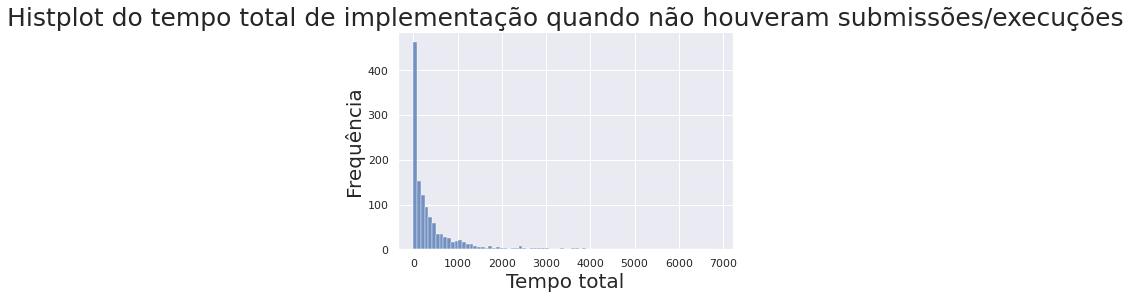

In [30]:
# estão concentradas principalmente nos primeiros semestres de cada ano
# onde ocorre o ingresso dos calouros
plt.title('Histplot do tempo total de implementação quando não houveram submissões/execuções', {'fontsize': 25})
ax = sns.histplot(x='tempo_total', data=nao_tentou)
ax.set_ylabel('Frequência', {'fontsize':20} )
ax.set_xlabel('Tempo total', {'fontsize':20} )
plt.show()

In [31]:
nao_tentou.tempo_total.describe()

count    1270.000000
mean      435.733178
std       718.066372
min         0.000000
25%        35.411250
50%       181.393000
75%       495.763750
max      6877.150000
Name: tempo_total, dtype: float64

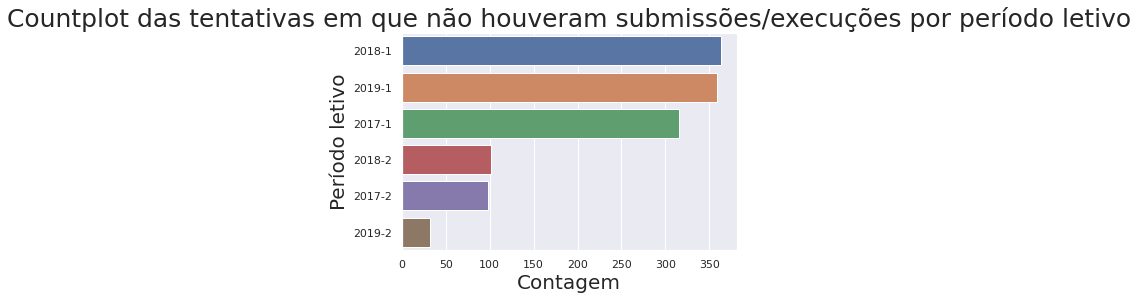

In [32]:
# estão concentradas principalmente nos primeiros semestres de cada ano
# onde ocorre o ingresso dos calouros
plt.title('Countplot das tentativas em que não houveram submissões/execuções por período letivo', {'fontsize': 25})
ax = sns.countplot(y='periodo', data=nao_tentou, order=nao_tentou.periodo.value_counts().index)
ax.set_ylabel('Período letivo', {'fontsize':20} )
ax.set_xlabel('Contagem', {'fontsize':20} )
plt.show()

In [33]:
nao_tentou.estudante.nunique()

709

In [34]:
# percentual de estudantes com esse comportamento.
nao_tentou.estudante.nunique() / tentativas_exam.estudante.nunique()

0.46552856204858833

In [35]:
tentativas_exam = tentativas_exam[~tentativas_exam.index.isin(nao_tentou.index)]

### 4.4 - Calculando as varíaveis dependentes (alvos)

Como variáveis dependentes iremos avaliar:

- A quantidade média de submissões em cada questão;
- O tempo médio de implementação com foco, em cada questão; e
- A taxa de acerto em cada questão.

In [36]:
# criando um novo dataframe para as variáveis dependentes
tentativas_agrupado = pd.DataFrame()

# obtendo os códigos das questões
tentativas_agrupado['exercicio'] = tentativas_exam.groupby('exercicio')['exercicio'].count().index
# obtendo a quantidade de tentativas feitas para cada questão.
tentativas_agrupado['tentativas'] = tentativas_exam.groupby('exercicio')['exercicio'].count().values

tentativas_agrupado.head()

,exercicio,tentativas
0,196,11
1,1002,17
2,1018,15
3,1019,13
4,1020,22


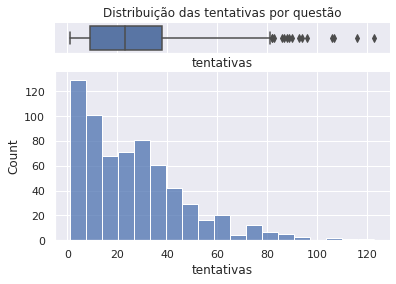

In [37]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_agrupado.tentativas, ax=ax_box)
sns.histplot(tentativas_agrupado.tentativas, ax=ax_hist)

ax_box.set_title('Distribuição das tentativas por questão')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

A análise estatística da quantidade de tentativas revela que:

- As base tem em média 26 tentativas para cada questão.
- Metade das questões têm até 23 tentativas.
- Existem questões com apenas um único registro de tentativa.
- A questão mais utilizada apresenta 123 tentativas. 


In [38]:
# estatísticas da quantidade de submissões
tentativas_agrupado.tentativas.describe()

count    653.000000
mean      26.606432
std       21.010436
min        1.000000
25%        9.000000
50%       23.000000
75%       38.000000
max      123.000000
Name: tentativas, dtype: float64

#### 4.4.1 Número médio de submissões

A analisando da distribuição do atributo `n_submissões` revela uma grande quantidade de __outliers__. Por meio da análise dos logs disponíveis no dataset foi constado que mesmo após acertar uma questão, muitos estudantes permanecem realizando submissões para a correção automática.

Isso adiciona muita distorção nos dados e torna seu uso como variável dependente duvidoso. Entrentanto, será calculado o número médio de submissões por questão para um possível uso futuro.

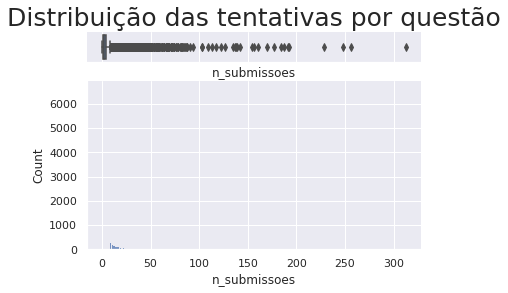

In [39]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam.n_submissoes, ax=ax_box)
sns.histplot(tentativas_exam.n_submissoes, ax=ax_hist)

ax_box.set_title('Distribuição das tentativas por questão', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

A análise estatística da quantidade de submissões revela que:

- Durante avaliações são feitas em média 04 submissões correção automática.
- Apresenta desvio padrão 9,69.
- Metade das tentativas apresenta até 02 submissões.
- O máximo de submissões registrado foi de 313.
- Existem 233 tentativas (~1,34%)  com uma quantidade de submissões distante da média em 3 desvios padrões ou mais.
- Existem 2133 tentativas (~12,28%) com uma quantidade de sumissões acima do limite superior (outliers pelo método IQR).


In [40]:
# estatísticas da quantidade de submissões
tentativas_exam.n_submissoes.describe()

count    17374.000000
mean         4.323817
std          9.692510
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        313.000000
Name: n_submissoes, dtype: float64

In [41]:
# outliers na distribuição da quantidade de submissões
z_threshold = 3.0

z = np.abs(stats.zscore(tentativas_exam.n_submissoes))
z[z > z_threshold].size

233

In [42]:
# percentual de outliers na distribuição da quantidade de submissões
z[z > z_threshold].size / tentativas_exam.shape[0]

0.013410843789570623

In [43]:
q1 = tentativas_exam.n_submissoes.quantile(.25)
q3 = tentativas_exam.n_submissoes.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

print('Quantidade de outliers: ', tentativas_exam[(tentativas_exam.n_submissoes < li) | (tentativas_exam.n_submissoes > ls)].shape[0])

Limite superior 8.5
Limite inferior -3.5
Quantidade de outliers:  2133


Analisando agora a quantidade de submissões somente nas tentativas em que houve sucesso, temos que:

- Em média são feitas aproximadamente 04 submissões, condizente com a amostra original.
- Metade das tentativas solucionou a questão com 02 ou menos submissões.
- Apresenta desvio padrão 7,69, menor que a amostra original.
- O máximo de submissões feitas foi de 184.
- Existem 164 tentativas (~1,38%) com uma quantidade de submissões distante da média em 3 desvios padrões ou mais.
- Existem 1230 tentativas (~10,36%) com uma quantidade de submissões acima do limite superior (outliers segundo IQR).

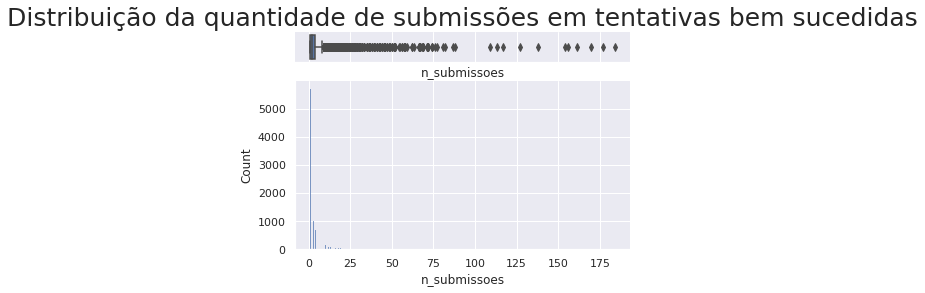

In [44]:
# somente as tentativas que acertaram as questões
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam[tentativas_exam.acertou].n_submissoes, ax=ax_box)
sns.histplot(tentativas_exam[tentativas_exam.acertou].n_submissoes, ax=ax_hist)

ax_box.set_title('Distribuição da quantidade de submissões em tentativas bem sucedidas', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [45]:
# estatísticas da distribuição da quantidade de submissões com êxito
tentativas_exam[tentativas_exam.acertou].n_submissoes.describe()

count    11877.000000
mean         3.950324
std          7.685522
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        184.000000
Name: n_submissoes, dtype: float64

In [46]:
# quantidade de outliers na distribuição da quantidade de submissões com êxito
z = np.abs(stats.zscore(tentativas_exam[tentativas_exam.acertou].n_submissoes))
z[z > z_threshold].size

164

In [47]:
# percentual de outliers na distribuição da quantidade de submissões com êxito
z[z > z_threshold].size / tentativas_exam[tentativas_exam.acertou].shape[0]

0.013808200724088575

In [48]:
q1 = tentativas_exam[tentativas_exam.acertou].n_submissoes.quantile(.25)
q3 = tentativas_exam[tentativas_exam.acertou].n_submissoes.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

temp = tentativas_exam[tentativas_exam.acertou]
print('Quantidade de outliers: ', temp[(temp.n_submissoes < li) | (temp.n_submissoes > ls)].shape[0])

Limite superior 8.5
Limite inferior -3.5
Quantidade de outliers:  1230


Fazendo a mesma análise para a quantidade de submissões em tentativas que houve fracasso, temos que:

- Em média são feitas 05 submissões, mais que a média global.
- Apresentar desvio padrão 12,98, maior que a amostra original.
- Metade das tentativas apresenta 01 submissão ou menos.
- O máximo de submissões feitas foi de 313.
- Existem 70 tentativas (~1,27%) com um quantidade de submissões distante da média em 3 desvios padrões ou mais.
- Existem 722 tentativas (~10,82%) com uma quantidade de submissões acima do limite superior (outliers segundo IQR).

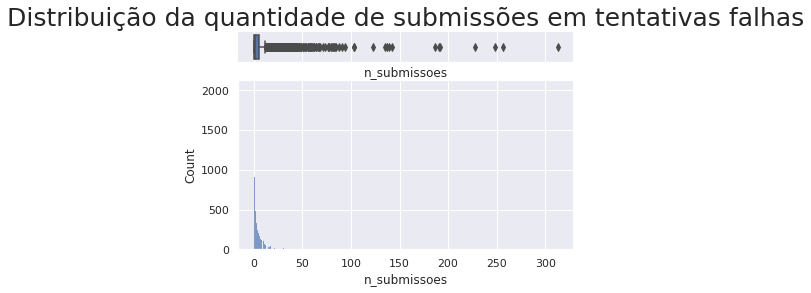

In [49]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam[~tentativas_exam.acertou].n_submissoes, ax=ax_box)
sns.histplot(tentativas_exam[~tentativas_exam.acertou].n_submissoes, ax=ax_hist)

ax_box.set_title('Distribuição da quantidade de submissões em tentativas falhas', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [50]:
# estatísticas da quantidade de submissões nas tentativas falhas
tentativas_exam[~tentativas_exam.acertou].n_submissoes.describe()

count    5497.000000
mean        5.130799
std        12.975897
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       313.000000
Name: n_submissoes, dtype: float64

In [51]:
# quantidade de outliers na distribuição da quantidade de submissões dentre as tentativas falhas
z = np.abs(stats.zscore(tentativas_exam[~tentativas_exam.acertou].n_submissoes))
z[z > z_threshold].size

70

In [52]:
q1 = tentativas_exam[~tentativas_exam.acertou].n_submissoes.quantile(.25)
q3 = tentativas_exam[~tentativas_exam.acertou].n_submissoes.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

temp = tentativas_exam[~tentativas_exam.acertou]
print('Quantidade de outliers: ', temp[(temp.n_submissoes < li) | (temp.n_submissoes > ls)].shape[0])

Limite superior 12.5
Limite inferior -7.5
Quantidade de outliers:  595


Por fim, a média de submissões por questão é salva no dataframe `tentativas_agrupado`.

In [53]:
tentativas_agrupado['media_submissoes'] = tentativas_exam.groupby('exercicio')['n_submissoes'].mean().values
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes
0,196,11,5.909091
1,1002,17,1.176471
2,1018,15,2.466667
3,1019,13,4.923077
4,1020,22,6.136364


#### 4.4.2 Tempo médio de implementação

O cálculo tanto do tempo de implementação (`tempo_total`) é feito com dados extraídos dos arquivos de log do CodeMirror (ambiente de codificação do Codebench). Nesse arquivos são registradas as interações do estudante com o ambiente (edições de código) e também algums eventos (ganho de foco, perda de foco, navegação entre menus, rolagem, etc.). O tempo de solução é calculado pelo somatório do intervalo de tempo entre dois registros (eventos) consecutivos, ocorridos enquanto a área de codificação esteja em foco. Entretanto, foram observados longos intervalos de tempo sem nenhuma interação por parte do estudante com a área de codificação. Isso pode ser justificado pelo fato de que durante as tentativas o estudante pode executar ações que não estejam vinculadas com a implementação da solução da questão, como por exemplo ausentar-se para ir ao banheiro, momentos de distração, conversas paralelas, releitura do enunciado ou até mesmo o abandono da questão. 

Isso compromete em princípio a validade dessa variável. Para tentar diminuir o viés dos dados foi definido arbitrariamente como `limiar de inatividade`, qualquer intervalo de tempo superior a 360 segundos em que não houver interação com o ambiente de codificação. Com base nesse limiar foram então calculados os tempos de implementação com foco (`tempo_foco`), desconsiderando os intervalos superiores a 360 segundos, entre dois registros consecutivos.

Embora essa variável esteja descartada para esse estudo, faremos ainda assim o cálculo do tempo médio de implementação com foco, para um possível uso futuro.

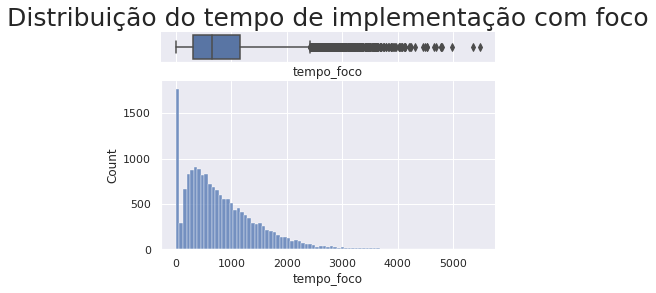

In [54]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam.tempo_foco, ax=ax_box)
sns.histplot(tentativas_exam.tempo_foco, ax=ax_hist)

ax_box.set_title('Distribuição do tempo de implementação com foco', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

A análise estatística do tempo de implementação com foco revela que:

- Durante avaliações é gasto em média aproximadamente 13 minutos e meio na implementação de uma solução.
- Apresenta desvio padrão 674,80.
- Em metade das tentativas são gastos até 11 minutos.
- O máximo de tempo gasto numa implementação foi de um pouco mais de 91 minutos.
- Não existem tentativas com tempo de implementação distante da média em 3 desvios padrões ou mais.
- Existem 477 tentativas (~2,75%)  com tempo de implementação acima do limite superior (outliers segundo IQR).


In [55]:
# estatísticas do tempo de implementação
tentativas_exam.tempo_foco.describe()

count    17357.000000
mean       809.482530
std        674.803687
min          0.000000
25%        316.387000
50%        653.547000
75%       1156.160000
max       5481.428000
Name: tempo_foco, dtype: float64

In [56]:
# outliers na distribuição do tempo de implementação
z = np.abs(stats.zscore(tentativas_exam.tempo_foco))
z[z > z_threshold].size

0

In [57]:
q1 = tentativas_exam.tempo_foco.quantile(.25)
q3 = tentativas_exam.tempo_foco.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

print('Quantidade de outliers: ', tentativas_exam[(tentativas_exam.tempo_foco < li) | (tentativas_exam.tempo_foco > ls)].shape[0])

Limite superior 2415.8195000000005
Limite inferior -943.2725000000003
Quantidade de outliers:  477


Ja análise estatística do tempo de implementação com foco para tentativas bem sucedidas revela que:

- São gastos em média aproximadamente 11 minutos na implementação correta de uma solução.
- Apresenta desvio padrão 575,76.
- Em metade das tentativas são gastos até 9 minutos na implementação correta de uma questão.
- O máximo de tempo gasto numa implementação correta foi pouco mais de 76 minutos.
- Não existem tentativas bem sucedidas com tempo de implementação distante da média em 3 desvios padrões ou mais.
- Existem 428 tentativas (~3,61%) com tempo de implementação acima do limite superior (outliers segundo IQR).


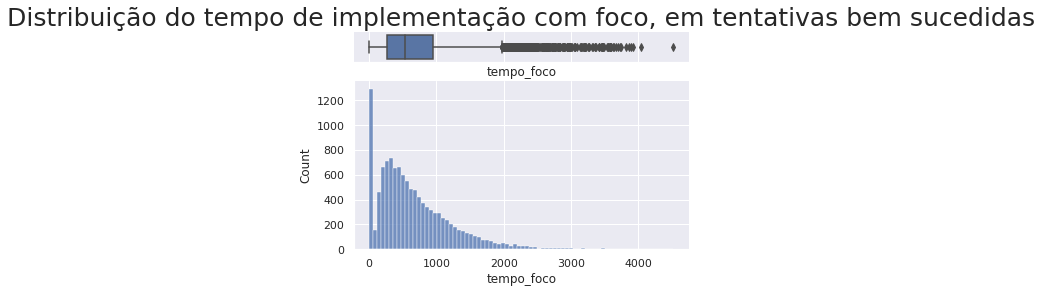

In [58]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam[tentativas_exam.acertou].tempo_foco, ax=ax_box)
sns.histplot(tentativas_exam[tentativas_exam.acertou].tempo_foco, ax=ax_hist)

ax_box.set_title('Distribuição do tempo de implementação com foco, em tentativas bem sucedidas', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [59]:
tentativas_exam[tentativas_exam.acertou].tempo_foco.describe()

count    11866.000000
mean       675.589962
std        575.755219
min          0.000000
25%        270.193250
50%        535.162500
75%        950.954000
max       4523.232000
Name: tempo_foco, dtype: float64

In [60]:
z = np.abs(stats.zscore(tentativas_exam[tentativas_exam.acertou].tempo_foco))
z[z > z_threshold].size

0

In [61]:
q1 = tentativas_exam[tentativas_exam.acertou].tempo_foco.quantile(.25)
q3 = tentativas_exam[tentativas_exam.acertou].tempo_foco.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

temp = tentativas_exam[tentativas_exam.acertou]
print('Quantidade de outliers: ', temp[(temp.tempo_foco < li) | (temp.tempo_foco > ls)].shape[0])

Limite superior 1972.0951250000003
Limite inferior -750.9478750000003
Quantidade de outliers:  428


Por sua vez, a análise estatística do tempo de implementação com foco para tentativas falhas revela que:

- São despendidos em média mais de 18 minutos nas implementações.
- Apresenta desvio padrão 775,02.
- Em metade das tentativas são gastos até 17 minutos na implementação.
- O máximo de tempo gasto numa implementação foi de aproximadamente uma hora e meia.
- Não existem tentativas bem sucedidas com tempo de implementação distante da média em 3 desvios padrões ou mais.
- Existem 114 tentativas (~2,62%) com tempo de implementação acima do limite superior (outliers segundo IQR).


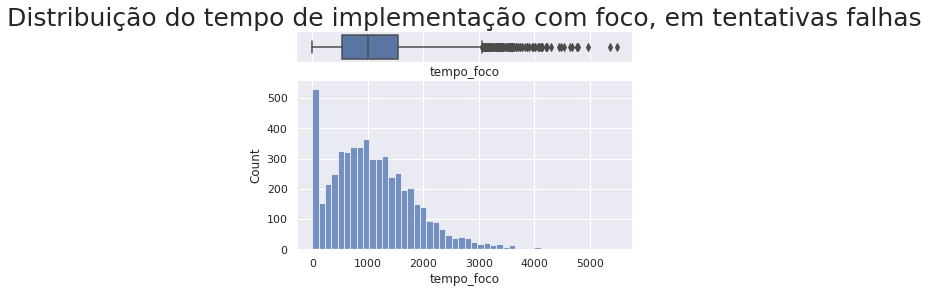

In [62]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_exam[~tentativas_exam.acertou].tempo_foco, ax=ax_box)
sns.histplot(tentativas_exam[~tentativas_exam.acertou].tempo_foco, ax=ax_hist)

ax_box.set_title('Distribuição do tempo de implementação com foco, em tentativas falhas', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [63]:
tentativas_exam[~tentativas_exam.acertou].tempo_foco.describe()

count    5491.000000
mean     1098.823126
std       775.023526
min         0.000000
25%       536.034000
50%       998.232000
75%      1545.270500
max      5481.428000
Name: tempo_foco, dtype: float64

In [64]:
z = np.abs(stats.zscore(tentativas_exam[~tentativas_exam.acertou].tempo_foco))
z[z > z_threshold].size

0

In [65]:
q1 = tentativas_exam[~tentativas_exam.acertou].tempo_foco.quantile(.25)
q3 = tentativas_exam[~tentativas_exam.acertou].tempo_foco.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

temp = tentativas_exam[~tentativas_exam.acertou]
print('Quantidade de outliers: ', temp[(temp.tempo_foco < li) | (temp.tempo_foco > ls)].shape[0])

Limite superior 3059.12525
Limite inferior -977.8207500000002
Quantidade de outliers:  114


Por fim, a média de tempo de implementação com foco por questão é salva no dataframe `tentativas_agrupado`.

In [66]:
tentativas_agrupado['media_tempo_foco'] = tentativas_exam.groupby('exercicio')['tempo_foco'].mean().values
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco
0,196,11,5.909091,1019.246000
1,1002,17,1.176471,590.561118
2,1018,15,2.466667,669.600667
3,1019,13,4.923077,808.980846
4,1020,22,6.136364,717.621909


#### 4.4.3 Taxa de acerto

Para  cálculo da taxa de acerto será criado uma coluna no dataframe `tentativas_agrupado`.

In [67]:
tentativas_agrupado['taxa_acerto'] = np.nan
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco,taxa_acerto
0,196,11,5.909091,1019.246000,NaN
1,1002,17,1.176471,590.561118,NaN
2,1018,15,2.466667,669.600667,NaN
3,1019,13,4.923077,808.980846,NaN
4,1020,22,6.136364,717.621909,NaN


O cálculo da taxa de acerto é feito para cada linha do dataframe `tentativas_agrupado` obtendo o código da questão. De posse do código calculamos a quantidade de tentativas que acertaram a questão (`r`) e também a quantidade total de tentativas (`t`) para aquela questão.

Por fim, a taxa de acerto é obtida pela divisão `r / t` e então armazenada na coluna `taxa_acerto`.

In [68]:
# percorre cada linha do dataframe `tentativas_agrupado`
for idx in tentativas_agrupado.index:
    # obtêm o código do exercício
    code = tentativas_agrupado.loc[idx, 'exercicio']
    # calcula a quantidade de tentativas assertivas
    r = tentativas_exam[tentativas_exam.acertou & (tentativas_exam.exercicio==code)]['exercicio'].count()
    # calcula a quantidade total de tentativas
    t = tentativas_exam[tentativas_exam.exercicio==code]['exercicio'].count()
    # calcula e salva a taxa de acerto
    tentativas_agrupado.loc[idx, 'taxa_acerto'] = np.round(r/t, 2)

tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco,taxa_acerto
0,196,11,5.909091,1019.246000,0.55
1,1002,17,1.176471,590.561118,0.94
2,1018,15,2.466667,669.600667,0.87
3,1019,13,4.923077,808.980846,1.00
4,1020,22,6.136364,717.621909,0.82


In [69]:
tentativas_agrupado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   exercicio         653 non-null    int64  
 1   tentativas        653 non-null    int64  
 2   media_submissoes  653 non-null    float64
 3   media_tempo_foco  653 non-null    float64
 4   taxa_acerto       653 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 25.6 KB


A análise estatística da taxa de acerto revela que:

- A taxa de acerto médio das questões é de 66,8%.
- Apresenta desvio padrão 0,22.
- Em metade das questões têm taxa de acerto abaixo de 70%.
- Existem questões com 100% de acerto.
- Existem 13 questões (~1,99%) com taxa de acerto distante da média em 3 desvios padrões ou mais.
- Existem 14 questões (~2,14%) com taxa de acerto abaixo do limite inferior (outliers segundo IQR).


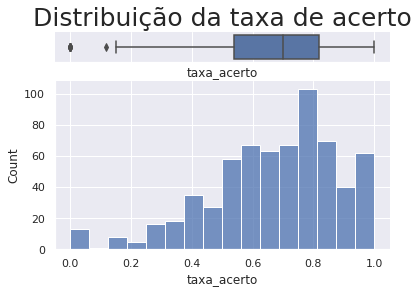

In [70]:
f, (ax_box, ax_hist) = plt.subplots(
    2,
    sharex=True, 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(tentativas_agrupado.taxa_acerto, ax=ax_box)
sns.histplot(tentativas_agrupado.taxa_acerto, ax=ax_hist)

ax_box.set_title('Distribuição da taxa de acerto', {'fontsize': 25})
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [71]:
tentativas_agrupado.taxa_acerto.describe()

count    653.000000
mean       0.668009
std        0.218030
min        0.000000
25%        0.540000
50%        0.700000
75%        0.820000
max        1.000000
Name: taxa_acerto, dtype: float64

In [72]:
z = np.abs(stats.zscore(tentativas_agrupado.taxa_acerto))
z[z > z_threshold].size

13

In [73]:
q1 = tentativas_agrupado.taxa_acerto.quantile(.25)
q3 = tentativas_agrupado.taxa_acerto.quantile(.75)
iqr = q3 - q1
ls = q3 + 1.5 * iqr
li = q1 - 1.5 * iqr
print('Limite superior', ls)
print('Limite inferior', li)

print('Quantidade de outliers: ', tentativas_agrupado[(tentativas_agrupado.taxa_acerto < li) | (tentativas_agrupado.taxa_acerto > ls)].shape[0])

Limite superior 1.2399999999999998
Limite inferior 0.12000000000000016
Quantidade de outliers:  14


### 4.5 - Discretização da taxa de acerto

Nossa ideia é utilizar a `taxa de acerto` em modelos de classificação, ou seja, não pretendemos estimar um valor contínuo e sim um valor discreto qualitativo.

Na literatura existem trabalhos que fazem uso da __Classificação de Questões por Índice de Facilidade__ segundo o __Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira__.

Faremos uso de uma adaptação binária e ternária dessa classificação.

In [74]:
# classificação segundo o índice de facilidade do INEP
tentativas_agrupado['classificacao_inep'] = pd.cut(
    tentativas_agrupado.taxa_acerto,
    bins=[0., .16, .41, .61, .86, 1.01],
    labels=['Muito Difícil', 'Difícil', 'Médio', 'Fácil', 'Muito Fácil'],
    include_lowest=True
)
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco,taxa_acerto,classificacao_inep
0,196,11,5.909091,1019.246000,0.55,Médio
1,1002,17,1.176471,590.561118,0.94,Muito Fácil
2,1018,15,2.466667,669.600667,0.87,Muito Fácil
3,1019,13,4.923077,808.980846,1.00,Muito Fácil
4,1020,22,6.136364,717.621909,0.82,Fácil


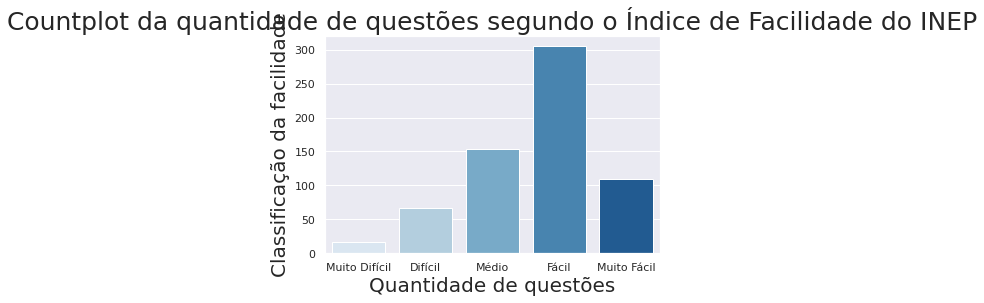

In [75]:
plt.title('Countplot da quantidade de questões segundo o Índice de Facilidade do INEP', {'fontsize': 25})
ax = sns.countplot(tentativas_agrupado.classificacao_inep, palette='Blues')
ax.set_xlabel('Quantidade de questões', {'fontsize':20})
ax.set_ylabel('Classificação da facilidade', {'fontsize':20})
#sns.countplot(tentativas_agrupado.classificacao_inep, palette='Blues', order=tentativas_agrupado.classificacao_inep.value_counts().index)
plt.show()

In [76]:
# classificação segundo o índice de facilidade do INEP
tentativas_agrupado['classificacao_ter'] = pd.cut(
    tentativas_agrupado.taxa_acerto,
    bins=[0.0, .41, .61, 1.01],
    labels=['Difícil', 'Médio', 'Fácil'],
    include_lowest=True
)
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco,taxa_acerto,classificacao_inep,classificacao_ter
0,196,11,5.909091,1019.246000,0.55,Médio,Médio
1,1002,17,1.176471,590.561118,0.94,Muito Fácil,Fácil
2,1018,15,2.466667,669.600667,0.87,Muito Fácil,Fácil
3,1019,13,4.923077,808.980846,1.00,Muito Fácil,Fácil
4,1020,22,6.136364,717.621909,0.82,Fácil,Fácil


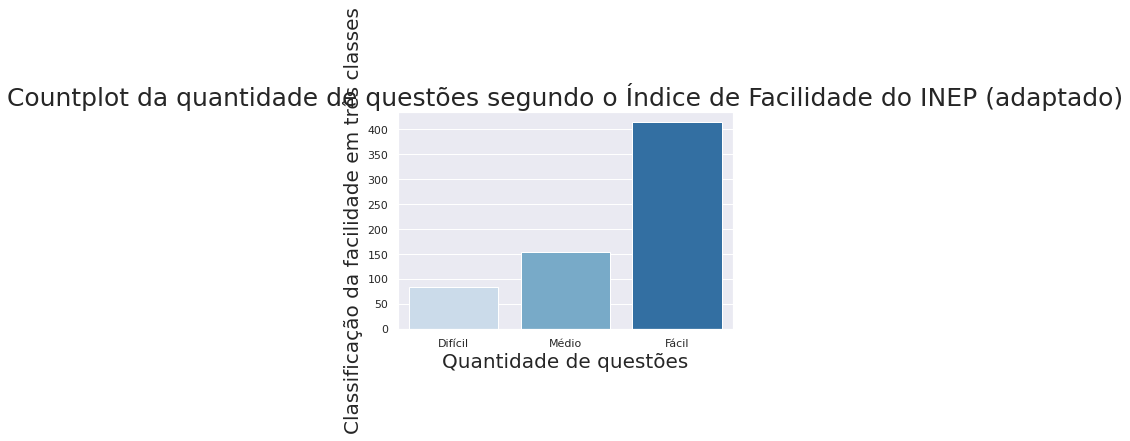

In [77]:
plt.title('Countplot da quantidade de questões segundo o Índice de Facilidade do INEP (adaptado)', {'fontsize': 25})
ax = sns.countplot(tentativas_agrupado.classificacao_ter, palette='Blues')
ax.set_xlabel('Quantidade de questões', {'fontsize':20})
ax.set_ylabel('Classificação da facilidade em três classes', {'fontsize':20})
#sns.countplot(tentativas_agrupado.classificacao_inep, palette='Blues', order=tentativas_agrupado.classificacao_inep.value_counts().index)
plt.show()

In [78]:
# classificação adaptada
tentativas_agrupado['classificacao_bin'] = pd.cut(
    tentativas_agrupado.taxa_acerto,
    bins=[0.0, .61, 1.01],
    labels=['Não Fácil', 'Fácil'],
    include_lowest=True
)
tentativas_agrupado.head()

,exercicio,tentativas,media_submissoes,media_tempo_foco,taxa_acerto,classificacao_inep,classificacao_ter,classificacao_bin
0,196,11,5.909091,1019.246000,0.55,Médio,Médio,Não Fácil
1,1002,17,1.176471,590.561118,0.94,Muito Fácil,Fácil,Fácil
2,1018,15,2.466667,669.600667,0.87,Muito Fácil,Fácil,Fácil
3,1019,13,4.923077,808.980846,1.00,Muito Fácil,Fácil,Fácil
4,1020,22,6.136364,717.621909,0.82,Fácil,Fácil,Fácil


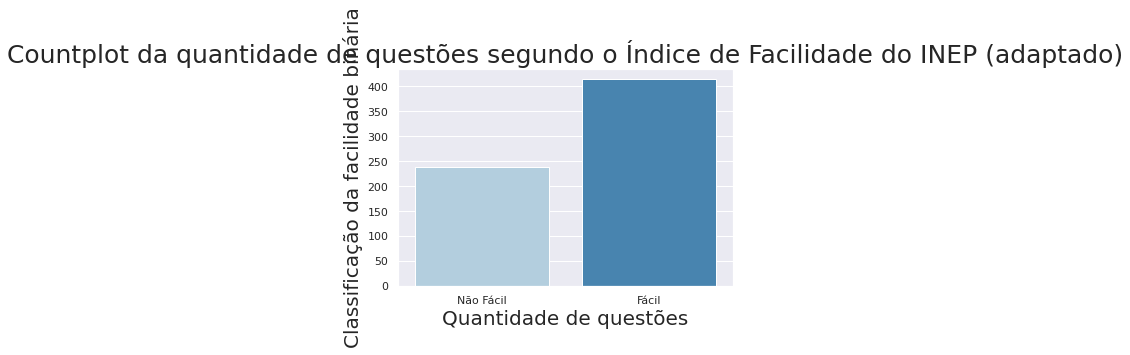

In [79]:
plt.title('Countplot da quantidade de questões segundo o Índice de Facilidade do INEP (adaptado)', {'fontsize': 25})
ax = sns.countplot(tentativas_agrupado.classificacao_bin, palette='Blues')
ax.set_xlabel('Quantidade de questões', {'fontsize':20})
ax.set_ylabel('Classificação da facilidade binária', {'fontsize':20})
#sns.countplot(tentativas_agrupado.classificacao_inep, palette='Blues', order=tentativas_agrupado.classificacao_inep.value_counts().index)
plt.show()

### 4.6 - Filtro de tentativas

Para reduzir possíveis distorções e garantir uma maior estabilidade da taxa de acerto é uma boa prática filtrar por questões com um número razoável de tentativas. 

Para a escolha de um valor ideal de limiar será conduziada uma análise do comportamento da distribuição da taxa de acerto segundo alguns limiares.


In [80]:
limiares = range(0, 101, 10) # valores de limiar para a quantidade de tentativas
rotulos = [f't >= {x}' for x in limiares] # labels para a legenda do gráfico
colors = plt.cm.get_cmap('hsv', len(limiares)) # padrão de cores do gráfico

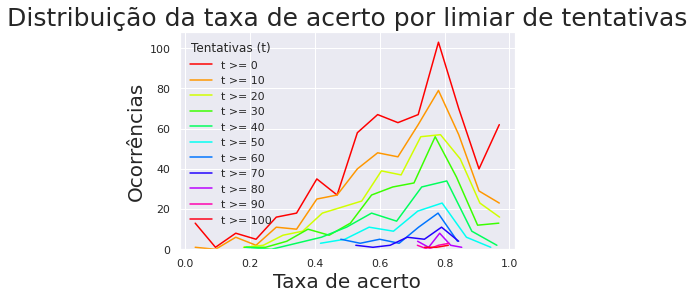

In [81]:
fig, ax = plt.subplots()
for i in range(len(limiares)): # plota a distribuição da taxa de acerto para cada um dos limiares
    sns.histplot(
        tentativas_agrupado[tentativas_agrupado.tentativas > limiares[i]].taxa_acerto,
        ax=ax,
        stat='count',
        element='poly',
        fill=False,
        kde=False,
        color=colors(i),
        legend=rotulos[i])

ax.set_title('Distribuição da taxa de acerto por limiar de tentativas', {'fontsize': 25})
ax.set_xlabel('Taxa de acerto', {'fontsize': 20})
ax.set_ylabel('Ocorrências', {'fontsize': 20})
ax.legend(rotulos, loc='upper left', title='Tentativas (t)')
plt.show()

O gráfico acima evidencia que quanto menor o valor escolhido com limiar mais distorção temos na taxa de acerto. 

In [82]:
quantidade_questoes = [
    tentativas_agrupado[tentativas_agrupado.tentativas > n].shape[0] 
    for n in limiares
]
quantidade_questoes # quantidade de questõs restantes por limiar

[653, 466, 355, 244, 129, 77, 49, 31, 16, 7, 4]

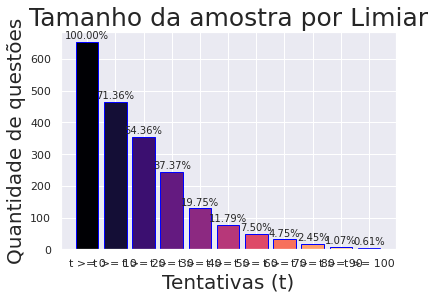

In [83]:
fig, ax = plt.subplots()
plt.bar(
    np.arange(len(rotulos)),
    quantidade_questoes,
    align='center',
    color=plt.cm.get_cmap('magma', len(quantidade_questoes)).colors,
    edgecolor='blue'
)
plt.xticks(np.arange(len(rotulos)), rotulos)
ax.set_title('Tamanho da amostra por Limiar', {'fontsize': 25})
ax.set_xlabel('Tentativas (t)', {'fontsize': 20})
ax.set_ylabel('Quantidade de questões', {'fontsize': 20})

for p in ax.patches: # adicionar o valor percental no gráfico
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/653:.2%}', (x + width/2, (y + height) + 10), ha='center')

plt.show()

Geralmente são utilizadas mais de 100 tentativas como limiar. Porém, valores muito altos como limiar, reduzem significativamente a amostra. Isso é observado no gráfico acima, onde apenas 0.61% das questões possuem 100 ou mais tentativas. 

Logo, faz-se necessário reduzir o limiar adotado de modo. Desse modo, adotaremos como limiar as questões com `20` ou mais tentativas pois esse valor reduz a distorção da taxa de acerto e também mantém mais da metade da amostra original (54.36%). 

In [84]:
alvos = tentativas_agrupado[tentativas_agrupado.tentativas > 20]
alvos.shape

(355, 8)

In [85]:
alvos.index = alvos.exercicio
alvos.drop(columns=['exercicio'], inplace=True)
alvos.sort_index(inplace=True)
alvos.head()

,tentativas,media_submissoes,media_tempo_foco,taxa_acerto,classificacao_inep,classificacao_ter,classificacao_bin
exercicio,,,,,,,
1020,22,6.136364,717.621909,0.82,Fácil,Fácil,Fácil
1027,58,5.327586,865.245172,0.86,Fácil,Fácil,Fácil
1028,60,6.700000,1034.030017,0.77,Fácil,Fácil,Fácil
1029,69,3.956522,981.815551,0.70,Fácil,Fácil,Fácil
1030,62,6.177419,857.934952,0.76,Fácil,Fácil,Fácil


### 4.7 - Obtendo as soluções dos instrutores

Comparando as questões com soluções fornecidas pelos instrutores e o conjunto de questões aplicado em avaliações, foi observado que não existem códigos de solução dos instrutores para todas as questões. Só dispomos de códigos de solução para 278 questões.

In [86]:
conjunto_instrutores = set(solucoes.codigo.unique())
conjunto_estudantes = set(alvos.index.unique())

len(conjunto_instrutores & conjunto_estudantes)

278

In [87]:
# filtra as soluções dos instrures
solucoes_instrutores = solucoes[solucoes.codigo.isin(conjunto_instrutores & conjunto_estudantes)]
solucoes_instrutores.shape

(278, 94)

Iremos então completar a amostra utilizando as soluçõs dos estudantes. Para isso, serão selecionadas a melhor solução de estudante para cada questão. Como critérios de seleção serão utilizados respecitivamente:
- 1º - Menor número de submissões.
- 2º - Menor número de execuções (testes).
- 3º - Menor número de erros durante submissões e testes.

__TODO__: verificar o uso das `k` melhores soluções dos estudantes.

In [88]:
# id das questõs sem solução de instrutor
not_solved = conjunto_estudantes - conjunto_instrutores

# atributos que devem ser copiadas para o dataset de soluções dos intrutores
atributos = solucoes.columns.to_list()
atributos[0] = 'exercicio' # no dataset de tentativas o identificador da questão é chamado de 'exercicio'

# novo dataset (soluções intrutores + estudantes)
solucoes_estudantes = pd.DataFrame(columns=atributos)

# percorre o dataset de tentativas buscando as melhores soluções de estudantes
for i, code in enumerate(not_solved):
    # filtra as tentativas que acertaram a questão
    temp = tentativas_exam[(tentativas_exam.exercicio==code) & tentativas_exam.acertou]
    # existe algum aluno que acertou a questão
    if (temp.shape[0] > 0):
        # aplica os critérios de seleção
        temp = temp[temp.n_submissoes == min(temp.n_submissoes)]
        temp = temp[temp.n_testes == min(temp.n_testes)]
        temp = temp[temp.n_erros == min(temp.n_erros)]
        # filtra os atributos desejados
        temp = temp[atributos]
        # recupera a primeira melhor solução
        solucoes_estudantes.loc[i] = temp.values[0]

solucoes_estudantes.rename(
    columns={
        'exercicio': 'codigo'
    },
    inplace=True
)

solucoes_estudantes.head()

,codigo,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,1033.0,1.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,3.0,11.0,7.0,14.0,14.0,21.0,42.808635,79.954453,1.909091,152.640320,0.026651,8.480018,0.0,5.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,5.0,2.166667,1.857143,3.000000
1,1034.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,4.0,6.0,6.0,10.000000,15.509775,1.000000,15.509775,0.005170,0.861654,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,1.333333,1.000000,8.000000
2,1035.0,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,0.0,2.0,2.0,4.0,2.0,4.0,6.0,6.0,10.000000,15.509775,1.000000,15.509775,0.005170,0.861654,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,3.0,1.500000,0.857143,15.333333
3,1036.0,1.0,0.0,0.0,8.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,4.0,2.0,4.0,6.0,6.0,10.000000,15.509775,1.000000,15.509775,0.005170,0.861654,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,1.333333,0.444444,1.500000
4,1037.0,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,0.0,2.0,2.0,4.0,2.0,4.0,6.0,6.0,10.000000,15.509775,1.000000,15.509775,0.005170,0.861654,0.0,3.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,3.0,1.500000,0.857143,1.333333


In [89]:
solucoes_estudantes.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 94 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   codigo                77 non-null     float64
 1   complexity            77 non-null     float64
 2   n_classes             77 non-null     float64
 3   n_functions           77 non-null     float64
 4   loc                   77 non-null     float64
 5   lloc                  77 non-null     float64
 6   sloc                  77 non-null     float64
 7   single_comments       77 non-null     float64
 8   comments              77 non-null     float64
 9   multilines            77 non-null     float64
 10  blank_lines           77 non-null     float64
 11  h1                    77 non-null     float64
 12  h2                    77 non-null     float64
 13  N1                    77 non-null     float64
 14  N2                    77 non-null     float64
 15  h                     77 

In [90]:
solucoes_merged = pd.concat([solucoes_instrutores, solucoes_estudantes], ignore_index=True)
solucoes_merged.head()

,codigo,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
0,2455.0,3.0,0.0,0.0,12.0,10.0,10.0,0.0,0.0,0.0,2.0,2.0,7.0,5.0,10.0,9.0,15.0,21.651484,47.548875,1.428571,67.926964,0.015850,3.773720,0.0,5.0,1.0,4.0,2.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,2.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,11.0,3.0,1.375000,0.846154,5.666667
1,3031.0,6.0,0.0,0.0,19.0,11.0,10.0,0.0,0.0,5.0,4.0,4.0,8.0,9.0,18.0,12.0,27.0,32.000000,96.793988,4.500000,435.572944,0.032265,24.198497,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,13.0,2.0,1.444444,0.650000,1.500000
2,2461.0,6.0,0.0,0.0,23.0,11.0,10.0,2.0,2.0,8.0,3.0,4.0,12.0,11.0,22.0,16.0,33.0,51.019550,132.000000,3.666667,484.000000,0.044000,26.888889,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,15.0,2.0,1.666667,0.625000,7.500000
3,1361.0,1.0,0.0,0.0,10.0,7.0,7.0,0.0,0.0,0.0,3.0,4.0,17.0,14.0,28.0,21.0,42.0,77.486868,184.477332,3.294118,607.690034,0.061492,33.760557,0.0,4.0,1.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,3.0,6.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,10.0,4.0,1.428571,0.909091,9.500000
4,1363.0,1.0,0.0,0.0,11.0,8.0,8.0,0.0,0.0,0.0,3.0,4.0,14.0,9.0,18.0,18.0,27.0,61.302969,112.587975,2.571429,289.511936,0.037529,16.083996,1.0,4.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,12.0,6.0,1.500000,1.000000,7.166667


In [91]:
solucoes_merged.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 94 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   codigo                355 non-null    float64
 1   complexity            355 non-null    float64
 2   n_classes             355 non-null    float64
 3   n_functions           355 non-null    float64
 4   loc                   355 non-null    float64
 5   lloc                  355 non-null    float64
 6   sloc                  355 non-null    float64
 7   single_comments       355 non-null    float64
 8   comments              355 non-null    float64
 9   multilines            355 non-null    float64
 10  blank_lines           355 non-null    float64
 11  h1                    355 non-null    float64
 12  h2                    355 non-null    float64
 13  N1                    355 non-null    float64
 14  N2                    355 non-null    float64
 15  h                     3

In [92]:
solucoes_merged.index = solucoes_merged.codigo.values.astype(int)
solucoes_merged.drop(columns='codigo', inplace=True)
solucoes_merged.head()

,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars
2455,3.0,0.0,0.0,12.0,10.0,10.0,0.0,0.0,0.0,2.0,2.0,7.0,5.0,10.0,9.0,15.0,21.651484,47.548875,1.428571,67.926964,0.015850,3.773720,0.0,5.0,1.0,4.0,2.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,2.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,11.0,3.0,1.375000,0.846154,5.666667
3031,6.0,0.0,0.0,19.0,11.0,10.0,0.0,0.0,5.0,4.0,4.0,8.0,9.0,18.0,12.0,27.0,32.000000,96.793988,4.500000,435.572944,0.032265,24.198497,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,13.0,2.0,1.444444,0.650000,1.500000
2461,6.0,0.0,0.0,23.0,11.0,10.0,2.0,2.0,8.0,3.0,4.0,12.0,11.0,22.0,16.0,33.0,51.019550,132.000000,3.666667,484.000000,0.044000,26.888889,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,15.0,2.0,1.666667,0.625000,7.500000
1361,1.0,0.0,0.0,10.0,7.0,7.0,0.0,0.0,0.0,3.0,4.0,17.0,14.0,28.0,21.0,42.0,77.486868,184.477332,3.294118,607.690034,0.061492,33.760557,0.0,4.0,1.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,3.0,6.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,10.0,4.0,1.428571,0.909091,9.500000
1363,1.0,0.0,0.0,11.0,8.0,8.0,0.0,0.0,0.0,3.0,4.0,14.0,9.0,18.0,18.0,27.0,61.302969,112.587975,2.571429,289.511936,0.037529,16.083996,1.0,4.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,12.0,6.0,1.500000,1.000000,7.166667


In [93]:
solucoes_merged.shape

(355, 93)

In [94]:
solucoes_merged.isnull().sum().sum()

0

### 4.8 Adicionando o módulo das questões como atributo

A disciplina de IPC está divida em sete módulos segundo a ementa da disciplina. 

- Módulo 01 - Variáveis e Estrutura Sequencial
- Módulo 02 - Estrutura Condicional
- Módulo 03 - Estrutura Condicional Encadeada
- Módulo 04 - Estrutura de Repetição por Condição
- Módulo 05 -Vetores e Strings
- Módulo 06 - Estrutura de Repetição por Contagem
- Módulo 07- Matrizes

Esses módulos são descritos nos títulos das atividades.

In [95]:
# aqui temos os títulos das atividades avaliativas
# já filtramos as atividades na seção 3.
avaliacoes.titulo.unique()

array(['TP 01: Variáveis e Estrutura Sequencial (2019)',
       'TP 02:  Est. Condicional Simples e Composta (2019)',
       'TP 1: Variáveis e Estrutura Sequencial',
       'TP 4: Estrutura de Repetição por Condição (while)',
       'TP 6: Estrutura de Repetição por Contagem (for)', 'Prova Final',
       'TP 5: Vetores e Strings',
       'TP 3 - Condicionais Encadeadas (if/elif/else)',
       'TP 2 - Condicional Simples e Composta (if/else)',
       'TP 7: Matrizes', 'Trabalho Pratico 7',
       'TP 3 – Condicionais Encadeadas (if/elif)',
       'TP 2 - Condicionais simples (if/else)',
       'TP1 - Variáveis e Estrutura Sequencial',
       'TP 2 - Condicionais compostos (if/else)',
       'TP 1 - Variáveis e Estrutura Sequencial',
       'TP03 – Condicionais Encadeadas (if/elif)',
       'TP01 - Variáveis e Estrutura Sequencial', 'Prova Final - Mateus',
       'TP 06 - Estrutura de Repetição por Contagem (for)',
       'TP02 - Condicionais simples (if/else)',
       'TP 03 – Condicio

Faremos então um mapeamento dos títulos das atividades para os respectivos módulos e então adicionaremos o módulo como atributo para as questões.

In [96]:
def format_titulo(titulo: str):
    titulo = re.sub(r'[\(\)\.\-\\:–\/]', ' ', titulo.lower())
    titulo = re.sub(r'[áàã]', 'a', titulo)
    titulo = re.sub(r'[éèẽ]', 'e', titulo)
    titulo = re.sub(r'[íìĩ]', 'i', titulo)
    titulo = re.sub(r'[óòõ]', 'o', titulo)
    titulo = re.sub(r'[úùũ]', 'u', titulo)
    titulo = re.sub(r'ç', 'c', titulo)
    titulo = re.sub(r'\sde\s', ' ', titulo)
    titulo = re.sub(r'\scod\s|\scodificacao\s', ' ', titulo)
    titulo = re.sub(r'\sest\s', ' estrutura ', titulo)
    titulo = re.sub(r'^tp|^lab\s|^lab01\s|^lab0\s|^laboratorio\s|^exercicios desafio\s|^desafios\s|^desafio\s', ' trabalho pratico ', titulo)
    titulo = re.sub(r'\s0\s', ' 00 ', titulo)
    titulo = re.sub(r'\s+', ' ', titulo)
    titulo = titulo.strip()
    titulo = re.sub('^trabalho pratico ', 'tp ', titulo)
    titulo = re.sub('^t ', 'tp ', titulo)
    titulo = re.sub(r'\s00\s', ' 0 ', titulo)
    titulo = re.sub(r'\s01\s', ' 1 ', titulo)
    titulo = re.sub(r'\s02\s', ' 2 ', titulo)
    titulo = re.sub(r'\s03\s', ' 3 ', titulo)
    titulo = re.sub(r'\s04\s', ' 4 ', titulo)
    titulo = re.sub(r'\s05\s', ' 5 ', titulo)
    titulo = re.sub(r'\s06\s', ' 6 ', titulo)
    titulo = re.sub(r'\s07\s', ' 7 ', titulo)
    
    if titulo.startswith('tp 0') or titulo.startswith('tp p'):
        return 'M01' # "tp 0" também envolve variáveis e estrutura sequencial
    elif titulo.startswith('tp 1') or titulo.startswith('tp v'):
        return 'M01'
    elif titulo.startswith('tp 2'):
        return 'M02'
    elif titulo.startswith('tp 3'):
        return 'M03'
    elif titulo.startswith('tp 4'):
        return 'M04'
    elif titulo.startswith('tp 5'):
        return 'M05'
    elif titulo.startswith('tp 6'):
        return 'M06'
    elif titulo.startswith('tp 7'):
        return 'M07'
    elif titulo.startswith('prova'):
        return 'PF'
    elif titulo.startswith('tp s') or titulo.startswith('tp r'):
        return 'EXTRA'

    return titulo.strip()

avaliacoes.titulo = avaliacoes.titulo.apply(format_titulo)
avaliacoes.titulo.unique()

array(['M01', 'M02', 'M04', 'M06', 'PF', 'M05', 'M03', 'M07', 'EXTRA'],
      dtype=object)

Iremos desconsiderar as atividades do tipo `prova final` e `tp extra` por serem uma combinação de todos os módulos das disciplinas.

In [97]:
not_tp = ['EXTRA', 'PF']
trabalhos_praticos = avaliacoes[~avaliacoes.titulo.isin(not_tp)]
trabalhos_praticos.head()

,periodo,turma,codigo,titulo,data_inicio,data_termino,linguagem,tipo,peso,n_blocos,blocos
0,2019-2,264,1977,M01,2019-09-02 08:00,2019-09-02 09:50,Python 3,exam,1.0,3,"[[1027, 1028, 1029, 1030, 1031, 1032, 3309], [..."
7,2019-2,264,2019,M02,2019-09-16 08:00,2019-09-16 09:50,Python 3,exam,1.0,3,"[[1390, 1391, 1392, 1393, 1394, 1395, 1396, 13..."
10,2019-2,260,2018,M02,2019-09-16 21:00,2019-09-16 21:55,Python 3,exam,1.0,2,"[[1390, 1391, 1392, 1393, 1394, 1396, 1398], [..."
12,2019-2,260,1971,M01,2019-09-02 21:00,2019-09-02 21:55,Python 3,exam,1.0,2,"[[1027, 1028, 1029, 1030, 1031, 1032, 3309], [..."
20,2019-2,259,1997,M01,2019-09-09 10:00,2019-09-09 10:55,Python 3,exam,1.0,2,"[[1027, 1028, 1029, 1030, 1031, 1032, 3309], [..."


Vamos construir um `dicionário` para os módulos das questões utilizando como chave o `id` da questão (código).

In [98]:
modulo_questao = dict()

for idx in trabalhos_praticos.index:
    titulo = trabalhos_praticos.loc[idx, 'titulo'] # recupera o titulo da atividade
    blocos = trabalhos_praticos.loc[idx, 'blocos'] # recupera o bloco de questões da atividade
    blocos = blocos.replace('[','').replace(']','').replace(' ','').split(',') # separa os códigos das questões que estão no bloco da ativida
    for questao in blocos: # adiciona o módulo da questão (titulo da atividade) no dicionário
        modulo_questao[int(questao)] = titulo

modulo_questao  

{196: 'M07',
 1002: 'M01',
 1018: 'M01',
 1019: 'M01',
 1020: 'M01',
 1021: 'M01',
 1022: 'M01',
 1023: 'M01',
 1024: 'M01',
 1025: 'M01',
 1026: 'M01',
 1027: 'M01',
 1028: 'M01',
 1029: 'M01',
 1030: 'M01',
 1031: 'M01',
 1032: 'M01',
 1033: 'M01',
 1034: 'M01',
 1035: 'M01',
 1036: 'M01',
 1037: 'M01',
 1038: 'M01',
 1080: 'M02',
 1081: 'M02',
 1082: 'M02',
 1083: 'M02',
 1084: 'M02',
 1085: 'M02',
 1086: 'M02',
 1087: 'M02',
 1088: 'M02',
 1089: 'M02',
 1090: 'M02',
 1091: 'M02',
 1092: 'M02',
 1093: 'M02',
 1094: 'M02',
 1095: 'M02',
 1096: 'M02',
 1097: 'M02',
 1098: 'M02',
 1109: 'M03',
 1111: 'M03',
 1113: 'M03',
 1114: 'M03',
 1115: 'M03',
 1117: 'M03',
 1119: 'M03',
 1120: 'M03',
 1122: 'M03',
 1125: 'M03',
 1126: 'M03',
 1127: 'M03',
 1146: 'M03',
 1147: 'M03',
 1148: 'M03',
 1149: 'M03',
 1285: 'M07',
 1286: 'M07',
 1287: 'M07',
 1288: 'M07',
 1289: 'M07',
 1290: 'M07',
 1291: 'M07',
 1292: 'M07',
 1293: 'M07',
 1294: 'M07',
 1295: 'M07',
 1296: 'M07',
 1297: 'M07',
 1298: 

Agora adicionaremos o atributo `módulo` ao dataframe de questões.

In [99]:
solucoes_merged['modulo'] = ''
for idx in solucoes_merged.index:
    solucoes_merged.at[idx, 'modulo'] = modulo_questao.get(idx)

solucoes_merged.head()

,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars,modulo
2455,3.0,0.0,0.0,12.0,10.0,10.0,0.0,0.0,0.0,2.0,2.0,7.0,5.0,10.0,9.0,15.0,21.651484,47.548875,1.428571,67.926964,0.015850,3.773720,0.0,5.0,1.0,4.0,2.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,2.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,11.0,3.0,1.375000,0.846154,5.666667,M03
3031,6.0,0.0,0.0,19.0,11.0,10.0,0.0,0.0,5.0,4.0,4.0,8.0,9.0,18.0,12.0,27.0,32.000000,96.793988,4.500000,435.572944,0.032265,24.198497,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,13.0,2.0,1.444444,0.650000,1.500000,M03
2461,6.0,0.0,0.0,23.0,11.0,10.0,2.0,2.0,8.0,3.0,4.0,12.0,11.0,22.0,16.0,33.0,51.019550,132.000000,3.666667,484.000000,0.044000,26.888889,0.0,5.0,1.0,6.0,4.0,10.0,2.0,0.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,1.0,0.0,15.0,2.0,1.666667,0.625000,7.500000,M03
1361,1.0,0.0,0.0,10.0,7.0,7.0,0.0,0.0,0.0,3.0,4.0,17.0,14.0,28.0,21.0,42.0,77.486868,184.477332,3.294118,607.690034,0.061492,33.760557,0.0,4.0,1.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,0.0,3.0,6.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,10.0,4.0,1.428571,0.909091,9.500000,M01
1363,1.0,0.0,0.0,11.0,8.0,8.0,0.0,0.0,0.0,3.0,4.0,14.0,9.0,18.0,18.0,27.0,61.302969,112.587975,2.571429,289.511936,0.037529,16.083996,1.0,4.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,1.0,1.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,12.0,6.0,1.500000,1.000000,7.166667,M01


Existe uma questão que ficou sem o atributo módulo. Ela pertence a uma atividade `extra`. Como é a única desse módulo iremos descartá-la.

In [100]:
solucoes_merged[solucoes_merged.modulo.isnull()]

,complexity,n_classes,n_functions,loc,lloc,sloc,single_comments,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,rpar,lsqb,rsqb,lbrace,rbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars,modulo
3229,1.0,0.0,0.0,14.0,7.0,8.0,2.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,4.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,7.0,7.0,3.0,3.0,0.0,0.0,4.0,0.0,2.0,1.0,1.0,0.0,16.0,9.0,2.285714,1.066667,4.555556,None


In [101]:
solucoes_merged[solucoes_merged.modulo.isnull()].index.values

array([3229])

In [102]:
alvos.columns

Index(['tentativas', 'media_submissoes', 'media_tempo_foco', 'taxa_acerto',
       'classificacao_inep', 'classificacao_ter', 'classificacao_bin'],
      dtype='object')

In [103]:
alvos.drop(solucoes_merged[solucoes_merged.modulo.isnull()].index.values, inplace=True)
solucoes_merged.drop(solucoes_merged[solucoes_merged.modulo.isnull()].index.values, inplace=True)

In [104]:
solucoes_merged.shape, alvos.shape

((354, 94), (354, 7))

In [105]:
solucoes_merged.isnull().sum().sum(), alvos.isnull().sum().sum()

(0, 0)

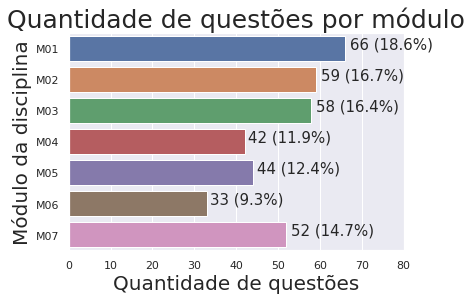

In [106]:
max_count = solucoes_merged.modulo.value_counts().max()

ax = sns.countplot(data=solucoes_merged, y='modulo', order=solucoes_merged.modulo.value_counts().sort_index().index)
ax.set_title('Quantidade de questões por módulo', {'fontsize': 25})
ax.set_xlabel('Quantidade de questões', {'fontsize': 20})
ax.set_ylabel('Módulo da disciplina', {'fontsize': 20})
ax.set_xlim(0, 80)

for p in ax.patches: # adicionar o valor percental no gráfico
    ax.annotate(f'{p.get_width()} ({p.get_width()/354*100:.1f}%)', (p.get_x()+p.get_width() * 1.02, p.get_y() + p.get_height()/2), fontsize=15)

plt.show()

In [107]:
solucoes_merged.columns

Index(['complexity', 'n_classes', 'n_functions', 'loc', 'lloc', 'sloc',
       'single_comments', 'comments', 'multilines', 'blank_lines', 'h1', 'h2',
       'N1', 'N2', 'h', 'N', 'calculated_N', 'volume', 'difficulty', 'effort',
       'bugs', 'time', 'imports', 'assignments', 'assignments_unique', 'kwds',
       'kwds_unique', 'lt_numbers', 'lt_strings', 'lt_booleans', 'lgc_op',
       'lgc_op_unique', 'and_op', 'or_op', 'not_op', 'arithmetic_op',
       'arithmetic_op_unique', 'add_op', 'minus_op', 'mult_op', 'div_op',
       'mod_op', 'power_op', 'div_floor_op', 'cmp_op', 'cmp_op_unique',
       'equal_op', 'not_eq_op', 'lt_op', 'gt_op', 'less_op', 'greater_op',
       'bitwise_op', 'bitwise_op_unique', 'bitwise_and', 'bitwise_or',
       'bitwise_xor', 'bitwise_not', 'lshift_op', 'rshift_op', 'identity_op',
       'membership_op', 'conditionals', 'ifs', 'elifs', 'elses', 'loops',
       'whiles', 'fors', 'breaks', 'continues', 'builtin_f',
       'builtin_f_unique', 'type_f', 'typ

## 5 - Engenharia de atributos

In [108]:
for c in solucoes_merged.columns:
    print(c, end=', ')

complexity, n_classes, n_functions, loc, lloc, sloc, single_comments, comments, multilines, blank_lines, h1, h2, N1, N2, h, N, calculated_N, volume, difficulty, effort, bugs, time, imports, assignments, assignments_unique, kwds, kwds_unique, lt_numbers, lt_strings, lt_booleans, lgc_op, lgc_op_unique, and_op, or_op, not_op, arithmetic_op, arithmetic_op_unique, add_op, minus_op, mult_op, div_op, mod_op, power_op, div_floor_op, cmp_op, cmp_op_unique, equal_op, not_eq_op, lt_op, gt_op, less_op, greater_op, bitwise_op, bitwise_op_unique, bitwise_and, bitwise_or, bitwise_xor, bitwise_not, lshift_op, rshift_op, identity_op, membership_op, conditionals, ifs, elifs, elses, loops, whiles, fors, breaks, continues, builtin_f, builtin_f_unique, type_f, type_f_unique, lambdas, lpar, rpar, lsqb, rsqb, lbrace, rbrace, commas, colons, dots, prints, inputs, len, uident, uident_unique, uident_mean, uident_per_line, uident_chars, modulo, 

### 5.1 - Agrupando atributos correlacionados ou repetidos

Alguns atributos extraídos dos códigos de solução ocorrem em pares, por exemplo, a quantidade de parenteses, colchetes e chaves. Por serem soluções corretas e funcionais esses atributos apresentam valores redundantes. Portanto, iremos eliminar um de cada.

In [109]:
solucoes_merged['comments'] = solucoes_merged['single_comments'] + solucoes_merged['comments']
solucoes_merged['has_comments'] = solucoes_merged['comments'] > 0

solucoes_merged.drop(['rpar', 'rsqb', 'rbrace', 'single_comments'], inplace=True, axis='columns')

rename = {
    'lpar': 'parenthesis',
    'lsqb': 'square_braces',
    'lbrace': 'curly_braces',
}
solucoes_merged.rename(rename, inplace=True)
solucoes_merged.shape

(354, 91)

### 5.2 - Criando atributos booleanos

Alguns modelos de aprendizado de máquina podem ter granho de desempenho se receberem atributos dicotômicos e no lugar de atributos contínuos ou discretos.

Portanto, serão criados mais alguns atributos para o modelo.

In [110]:
# atributos dos códigos de solução
solucoes_merged['has_operators'] = solucoes_merged['h1'] > 0
solucoes_merged['has_operands'] = solucoes_merged['h2'] > 0
solucoes_merged['has_imports'] = solucoes_merged['imports'] > 0
solucoes_merged['has_kwds'] = solucoes_merged['kwds_unique'] > 0
solucoes_merged['has_numbers'] = solucoes_merged['lt_numbers'] > 0
solucoes_merged['has_strs'] = solucoes_merged['lt_strings'] > 0
solucoes_merged['has_bools'] = solucoes_merged['lt_booleans'] > 0
solucoes_merged['has_lgc_op'] = solucoes_merged['lgc_op_unique'] > 0
solucoes_merged['has_arth_op'] = solucoes_merged['arithmetic_op_unique'] > 0
solucoes_merged['has_cmp_op'] = solucoes_merged['cmp_op_unique'] > 0
solucoes_merged['has_conditionals'] = solucoes_merged['conditionals'] > 0
solucoes_merged['has_ifs'] = solucoes_merged['ifs'] > 0
solucoes_merged['has_elifs'] = solucoes_merged['elifs'] > 0
solucoes_merged['has_elses'] = solucoes_merged['elses'] > 0
solucoes_merged['has_loops'] = solucoes_merged['loops'] > 0
solucoes_merged['has_fors'] = solucoes_merged['fors'] > 0
solucoes_merged['has_whiles'] = solucoes_merged['whiles'] > 0
solucoes_merged['has_add_sub'] = (solucoes_merged['add_op'] + solucoes_merged['minus_op']) > 0
solucoes_merged['has_mult_div'] = (solucoes_merged['mult_op'] + solucoes_merged['div_op'] + solucoes_merged['div_floor_op']) > 0
solucoes_merged['has_blocks'] = solucoes_merged['colons'] > 0

solucoes_merged.shape

(354, 111)

### 5.3 - Transformando atributos categóricos e booleanos em atributos numéricos

Os modelos de aprendizado de máquina utilizados neste trabalho fazem uso de atributos numéricos. Porém, além do atributo categórico `módulo` adicionado na seção 4.8, temos também os atributos booleanos gerados na seção anterior e que precisam ser convertidos para um formato numérico.

In [111]:
solucoes_merged.dtypes

complexity              float64
n_classes               float64
n_functions             float64
loc                     float64
lloc                    float64
sloc                    float64
comments                float64
multilines              float64
blank_lines             float64
h1                      float64
h2                      float64
N1                      float64
N2                      float64
h                       float64
N                       float64
calculated_N            float64
volume                  float64
difficulty              float64
effort                  float64
bugs                    float64
time                    float64
imports                 float64
assignments             float64
assignments_unique      float64
kwds                    float64
kwds_unique             float64
lt_numbers              float64
lt_strings              float64
lt_booleans             float64
lgc_op                  float64
lgc_op_unique           float64
and_op  

In [112]:
# verificando a ordem numérica dos códigos e módulos
solucoes_merged['modulo'] = solucoes_merged['modulo'].astype('category')
dict(zip(solucoes_merged['modulo'].cat.codes, solucoes_merged['modulo'] ) )

{0: 'M01', 1: 'M02', 2: 'M03', 3: 'M04', 4: 'M05', 5: 'M06', 6: 'M07'}

In [113]:
solucoes_merged['modulo'] = solucoes_merged['modulo'].cat.codes
solucoes_merged.modulo.unique()

array([2, 0, 3, 6, 1, 5, 4], dtype=int8)

In [114]:
# TODO simplify
def bool_to_int(x):
    if x is True:
        return 1
    elif x is False:
        return 0
    return x

solucoes_merged = solucoes_merged.applymap(bool_to_int)
solucoes_merged.dtypes

complexity              float64
n_classes               float64
n_functions             float64
loc                     float64
lloc                    float64
sloc                    float64
comments                float64
multilines              float64
blank_lines             float64
h1                      float64
h2                      float64
N1                      float64
N2                      float64
h                       float64
N                       float64
calculated_N            float64
volume                  float64
difficulty              float64
effort                  float64
bugs                    float64
time                    float64
imports                 float64
assignments             float64
assignments_unique      float64
kwds                    float64
kwds_unique             float64
lt_numbers              float64
lt_strings              float64
lt_booleans             float64
lgc_op                  float64
lgc_op_unique           float64
and_op  

## 6- Adicionando as métricas de inteligibilidade

As métricas de inteligibilidade foram obtidas do enunciado das questões. Esses enunciados estão em formato HTML e salvos no arquivo [enunciados.csv](https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/enunciados.csv).

Antes da extração de métricas os enunciados são pré-processados para remover caracteres indesejados (letras gregas, unidades monetárias, etc.) e substituir algumas expressões (latex, números e porcentagens) por termos mais genéricos e representativos.

Aṕos o pré-processamento, os enunciados são submetidos para extração de métricas de inteligibilidade na plataforma [Coh-Metrix-Port 3.0](http://fw.nilc.icmc.usp.br:23380/cohmetrixport), desenvolvida pelo [Núcleo Interinstitucional de Linguística Computacional](http://nilc.icmc.usp.br/). 

Coh-Metrix-Port 3.0 é uma ferramenta que usa Processamento de Linguagem Natural (PNL) para permitir a extração de 46 métricas textuais, que podem ser usadas para auxiliar na análise automatizada da legibilidade de texto. A descrição completa de cada uma das 46 métricas está disponível em: [NILC Metrix Doc](http://fw.nilc.icmc.usp.br:23380/metrixdoc)

Como a plataforma só permite a submissão de um enunciado por vez, o processo foi automatizado. O script de pré-processamento, submissão automatizada dos enunciados e download das métricas de legibilidade está disponível no arquivo [statement-miner.py](https://github.com/marcosmapl/dificuldade-questoes/blob/main/scripts/statement-miner.py)

Como não só temos interesse nos enunciados de todas as questões da base, somente nas 354 selecionadas neste trabalho, criamos o arquivo [enunciados-coh-metrix.csv](https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/enunciados-coh-metrix.csv) contendo apenas as métricas para as 354 questões abordadas aqui.

In [115]:
cohmetrix = pd.read_csv(
    'https://raw.githubusercontent.com/marcosmapl/dificuldade-questoes/main/datasets/enunciados-coh-metrix.csv',
    index_col='Unnamed: 0'
)

cohmetrix.name = 'Dataframe Métricas Coh-Metrix-Port'
cohmetrix.head()

,adj_arg_ovl,adj_stem_ovl,arg_ovl,stem_ovl,adjacent_refs,anaphoric_refs,words_before_main_verb,add_neg_conn_ratio,add_pos_conn_ratio,and_ratio,cau_neg_conn_ratio,cau_pos_conn_ratio,conn_ratio,if_ratio,log_neg_conn_ratio,log_pos_conn_ratio,logic_operators,negation_ratio,tmp_neg_conn_ratio,tmp_pos_conn_ratio,mean_noun_phrase,ttr,cw_freq,min_cw_freq,adjective_ratio,adverbs,content_words,function_words,personal_pronouns,pronoun_ratio,verbs,adjectives_ambiguity,adverbs_ambiguity,hypernyms_verbs,nouns_ambiguity,verbs_ambiguity,paragraphs,sentences,sentences_per_paragraph,syllables_per_content_word,words,words_per_sentence,flesch
1943,5.8,6.80000,8.53333,9.66667,0.0,0.0,1.00000,0.0,0.03053,0.02290,0.0,0.01527,0.04580,0.00000,0.0,0.00763,0.03053,0.0,0.0,0.00763,7.63889,0.62875,261434.09091,863.16667,0.09160,0.00763,0.67176,0.32824,0.00844,0.03053,0.11450,0.60000,0.00,0.80000,1.40000,5.00000,1.0,6.0,6.0,3.03409,131.0,21.83333,23.89249
3139,2.5,4.50000,2.66667,4.66667,0.0,0.0,1.33333,0.0,0.03571,0.00000,0.0,0.07143,0.07143,0.00000,0.0,0.05357,0.00000,0.0,0.0,0.00000,4.88889,0.64286,381582.86111,555.00000,0.17857,0.00000,0.64286,0.35714,0.00000,0.07143,0.16071,2.22222,0.00,0.66667,3.46667,10.62500,1.0,3.0,3.0,2.69444,56.0,18.66667,45.58119
1655,1.5,2.00000,1.23810,1.61905,0.0,0.0,1.00000,0.0,0.01031,0.00000,0.0,0.01031,0.01031,0.00000,0.0,0.01031,0.00000,0.0,0.0,0.00000,5.78571,0.64948,231630.36207,7555.57143,0.05155,0.01031,0.59794,0.40206,0.00000,0.07216,0.12371,1.20000,1.00,0.75000,3.28571,10.00000,1.0,7.0,7.0,2.72414,97.0,13.85714,53.35969
1979,1.5,1.83333,0.90476,1.38095,0.0,0.0,3.42857,0.0,0.01695,0.00847,0.0,0.04237,0.05085,0.00847,0.0,0.02542,0.01695,0.0,0.0,0.00000,4.86905,0.68105,286641.47887,6545.28571,0.05085,0.04237,0.60169,0.39831,0.01000,0.06780,0.16949,2.25000,3.75,1.05263,4.56410,6.85714,1.0,7.0,7.0,3.05634,118.0,16.85714,35.28093
1714,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.09091,0.03030,0.0,0.09091,0.12121,0.00000,0.0,0.06061,0.03030,0.0,0.0,0.00000,4.83333,0.84848,57883.42105,127.00000,0.15152,0.00000,0.57576,0.42424,0.00000,0.03030,0.09091,2.60000,0.00,1.66667,4.90909,16.50000,1.0,1.0,1.0,2.89474,33.0,33.00000,30.75818


In [116]:
cohmetrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 1943 to 1538
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adj_arg_ovl                 354 non-null    float64
 1   adj_stem_ovl                354 non-null    float64
 2   arg_ovl                     354 non-null    float64
 3   stem_ovl                    354 non-null    float64
 4   adjacent_refs               354 non-null    float64
 5   anaphoric_refs              354 non-null    float64
 6   words_before_main_verb      354 non-null    float64
 7   add_neg_conn_ratio          354 non-null    float64
 8   add_pos_conn_ratio          354 non-null    float64
 9   and_ratio                   354 non-null    float64
 10  cau_neg_conn_ratio          354 non-null    float64
 11  cau_pos_conn_ratio          354 non-null    float64
 12  conn_ratio                  354 non-null    float64
 13  if_ratio                    354

Verificando se existe diferença entre os __IDs__ do conjunto de soluções e do conjunto de métricas de legibilidade.

In [117]:
set(solucoes_merged.index) - set(cohmetrix.index)

set()

Como não há diferença, podemos então unificar o conjunto de soluções com o de métricas de legibilidade:

In [118]:
# ordenando ambos os conjuntos pelos IDs das questões
solucoes_merged.sort_index(inplace=True)
cohmetrix.sort_index(inplace=True)

data = pd.concat([solucoes_merged, cohmetrix], axis=1)
data.head()

,complexity,n_classes,n_functions,loc,lloc,sloc,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,lsqb,lbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars,modulo,has_comments,has_operators,has_operands,has_imports,has_kwds,has_numbers,has_strs,has_bools,has_lgc_op,has_arth_op,has_cmp_op,has_conditionals,has_ifs,has_elifs,has_elses,has_loops,has_fors,has_whiles,has_add_sub,has_mult_div,has_blocks,adj_arg_ovl,adj_stem_ovl,arg_ovl,stem_ovl,adjacent_refs,anaphoric_refs,words_before_main_verb,add_neg_conn_ratio,add_pos_conn_ratio,and_ratio,cau_neg_conn_ratio,cau_pos_conn_ratio,conn_ratio,if_ratio,log_neg_conn_ratio,log_pos_conn_ratio,logic_operators,negation_ratio,tmp_neg_conn_ratio,tmp_pos_conn_ratio,mean_noun_phrase,ttr,cw_freq,min_cw_freq,adjective_ratio,adverbs,content_words,function_words,personal_pronouns,pronoun_ratio,verbs,adjectives_ambiguity,adverbs_ambiguity,hypernyms_verbs,nouns_ambiguity,verbs_ambiguity,paragraphs,sentences,sentences_per_paragraph,syllables_per_content_word,words,words_per_sentence,flesch
1020,1.0,0.0,0.0,8.0,7.0,7.0,0.0,0.0,1.0,3.0,8.0,4.0,8.0,11.0,12.0,28.754888,41.513179,1.500000,62.269769,0.013838,3.459432,0.0,6.0,1.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,4.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,12.0,6.0,1.714286,1.333333,3.0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.50,0.66667,0.61905,0.7619,0.0,0.0,0.71429,0.00000,0.02326,0.01163,0.0,0.03488,0.04651,0.0,0.00000,0.03488,0.01163,0.0,0.0,0.0,4.23810,0.63953,215242.44000,6970.57143,0.08140,0.00000,0.58140,0.41860,0.0,0.05814,0.10465,1.66667,0.0,1.00000,3.56250,5.00000,1.0,7.0,7.0,2.74000,86.0,12.28571,59.29523
1027,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,2.0,2.0,7.0,4.0,8.0,9.0,12.0,21.651484,38.039100,1.142857,43.473257,0.012680,2.415181,0.0,3.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,2.0,1.750000,1.000000,9.0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.50,1.00000,0.50000,1.1000,0.0,0.0,1.00000,0.00000,0.04000,0.01333,0.0,0.04000,0.05333,0.0,0.00000,0.04000,0.01333,0.0,0.0,0.0,5.03333,0.66667,278398.34091,1298.80000,0.04000,0.00000,0.58667,0.41333,0.0,0.08000,0.22667,1.33333,0.0,1.00000,5.40000,8.55556,1.0,5.0,5.0,2.63636,75.0,15.00000,57.64200
1028,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,2.0,2.0,7.0,4.0,8.0,9.0,12.0,21.651484,38.039100,1.142857,43.473257,0.012680,2.415181,0.0,3.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,2.0,1.750000,1.000000,7.5,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.75,1.00000,0.70000,0.9000,0.0,0.0,1.00000,0.01333,0.04000,0.01333,0.0,0.04000,0.06667,0.0,0.01333,0.04000,0.01333,0.0,0.0,0.0,4.96667,0.68000,178504.88889,2410.00000,0.02667,0.01333,0.60000,0.40000,0.0,0.05333,0.18667,6.00000,11.0,1.14286,5.04348,7.00000,1.0,5.0,5.0,2.57778,75.0,15.00000,57.64200
1029,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,2.0,2.0,7.0,4.0,8.0,9.0,12.0,21.651484,38

In [119]:
data.shape

(354, 154)

In [120]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 1020 to 3309
Data columns (total 154 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   complexity                  float64
 1   n_classes                   float64
 2   n_functions                 float64
 3   loc                         float64
 4   lloc                        float64
 5   sloc                        float64
 6   comments                    float64
 7   multilines                  float64
 8   blank_lines                 float64
 9   h1                          float64
 10  h2                          float64
 11  N1                          float64
 12  N2                          float64
 13  h                           float64
 14  N                           float64
 15  calculated_N                float64
 16  volume                      float64
 17  difficulty                  float64
 18  effort                      float64
 19  bugs                    

Não temos valores faltantes:

In [121]:
data.isnull().sum().sum()

0

## 7 - Adicionando as possíveis variáveis dependentes (alvos)

In [122]:
data = pd.concat([data, alvos], axis=1)
data.head()

,complexity,n_classes,n_functions,loc,lloc,sloc,comments,multilines,blank_lines,h1,h2,N1,N2,h,N,calculated_N,volume,difficulty,effort,bugs,time,imports,assignments,assignments_unique,kwds,kwds_unique,lt_numbers,lt_strings,lt_booleans,lgc_op,lgc_op_unique,and_op,or_op,not_op,arithmetic_op,arithmetic_op_unique,add_op,minus_op,mult_op,div_op,mod_op,power_op,div_floor_op,cmp_op,cmp_op_unique,equal_op,not_eq_op,lt_op,gt_op,less_op,greater_op,bitwise_op,bitwise_op_unique,bitwise_and,bitwise_or,bitwise_xor,bitwise_not,lshift_op,rshift_op,identity_op,membership_op,conditionals,ifs,elifs,elses,loops,whiles,fors,breaks,continues,builtin_f,builtin_f_unique,type_f,type_f_unique,lambdas,lpar,lsqb,lbrace,commas,colons,dots,prints,inputs,len,uident,uident_unique,uident_mean,uident_per_line,uident_chars,modulo,has_comments,has_operators,has_operands,has_imports,has_kwds,has_numbers,has_strs,has_bools,has_lgc_op,has_arth_op,has_cmp_op,has_conditionals,has_ifs,has_elifs,has_elses,has_loops,has_fors,has_whiles,has_add_sub,has_mult_div,has_blocks,adj_arg_ovl,adj_stem_ovl,arg_ovl,stem_ovl,adjacent_refs,anaphoric_refs,words_before_main_verb,add_neg_conn_ratio,add_pos_conn_ratio,and_ratio,cau_neg_conn_ratio,cau_pos_conn_ratio,conn_ratio,if_ratio,log_neg_conn_ratio,log_pos_conn_ratio,logic_operators,negation_ratio,tmp_neg_conn_ratio,tmp_pos_conn_ratio,mean_noun_phrase,ttr,cw_freq,min_cw_freq,adjective_ratio,adverbs,content_words,function_words,personal_pronouns,pronoun_ratio,verbs,adjectives_ambiguity,adverbs_ambiguity,hypernyms_verbs,nouns_ambiguity,verbs_ambiguity,paragraphs,sentences,sentences_per_paragraph,syllables_per_content_word,words,words_per_sentence,flesch,tentativas,media_submissoes,media_tempo_foco,taxa_acerto,classificacao_inep,classificacao_ter,classificacao_bin
1020,1.0,0.0,0.0,8.0,7.0,7.0,0.0,0.0,1.0,3.0,8.0,4.0,8.0,11.0,12.0,28.754888,41.513179,1.500000,62.269769,0.013838,3.459432,0.0,6.0,1.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,4.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,12.0,6.0,1.714286,1.333333,3.0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.50,0.66667,0.61905,0.7619,0.0,0.0,0.71429,0.00000,0.02326,0.01163,0.0,0.03488,0.04651,0.0,0.00000,0.03488,0.01163,0.0,0.0,0.0,4.23810,0.63953,215242.44000,6970.57143,0.08140,0.00000,0.58140,0.41860,0.0,0.05814,0.10465,1.66667,0.0,1.00000,3.56250,5.00000,1.0,7.0,7.0,2.74000,86.0,12.28571,59.29523,22,6.136364,717.621909,0.82,Fácil,Fácil,Fácil
1027,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,2.0,2.0,7.0,4.0,8.0,9.0,12.0,21.651484,38.039100,1.142857,43.473257,0.012680,2.415181,0.0,3.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,2.0,1.750000,1.000000,9.0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.50,1.00000,0.50000,1.1000,0.0,0.0,1.00000,0.00000,0.04000,0.01333,0.0,0.04000,0.05333,0.0,0.00000,0.04000,0.01333,0.0,0.0,0.0,5.03333,0.66667,278398.34091,1298.80000,0.04000,0.00000,0.58667,0.41333,0.0,0.08000,0.22667,1.33333,0.0,1.00000,5.40000,8.55556,1.0,5.0,5.0,2.63636,75.0,15.00000,57.64200,58,5.327586,865.245172,0.86,Fácil,Fácil,Fácil
1028,1.0,0.0,0.0,6.0,4.0,4.0,0.0,0.0,2.0,2.0,7.0,4.0,8.0,9.0,12.0,21.651484,38.039100,1.142857,43.473257,0.012680,2.415181,0.0,3.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0,2.0,1.750000,1.000000,7.5,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.75,1.00000,0.70000,0.9000,0.0,0.0,1.00000,0.01333,0.04000,0.01333,0.0,0.04000,0.06667,0.0,0.01333,0.04000,0.01333,0.0,0.0,0.0,4.96667,0.68000,178504.88889,2410.00000,0.0266

In [123]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 1020 to 3309
Data columns (total 161 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   complexity                  float64 
 1   n_classes                   float64 
 2   n_functions                 float64 
 3   loc                         float64 
 4   lloc                        float64 
 5   sloc                        float64 
 6   comments                    float64 
 7   multilines                  float64 
 8   blank_lines                 float64 
 9   h1                          float64 
 10  h2                          float64 
 11  N1                          float64 
 12  N2                          float64 
 13  h                           float64 
 14  N                           float64 
 15  calculated_N                float64 
 16  volume                      float64 
 17  difficulty                  float64 
 18  effort                      float64 
 19  bug

## 8 - Gráficos

### 8.1 - Catplots

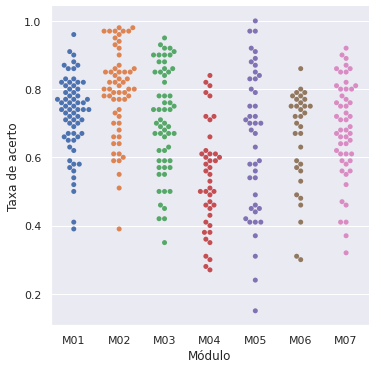

In [124]:
g = sns.catplot(x='modulo', y='taxa_acerto', data=data, kind='swarm')
g.add_legend()
g.set_axis_labels("Módulo", "Taxa de acerto")
g.set_xticklabels(np.sort(trabalhos_praticos.titulo.unique()))
plt.show()

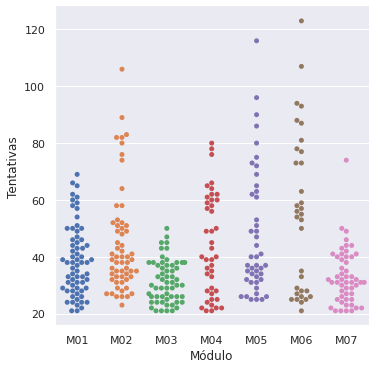

In [125]:
g = sns.catplot(x='modulo', y='tentativas', data=data, kind='swarm')
g.add_legend()
g.set_axis_labels("Módulo", "Tentativas")
g.set_xticklabels(np.sort(trabalhos_praticos.titulo.unique()))
plt.show()

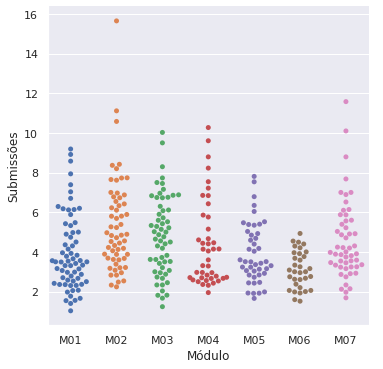

In [126]:
g = sns.catplot(x='modulo', y='media_submissoes', data=data, kind='swarm')
g.add_legend()
g.set_axis_labels("Módulo", "Submissões")
g.set_xticklabels(np.sort(trabalhos_praticos.titulo.unique()))
plt.show()

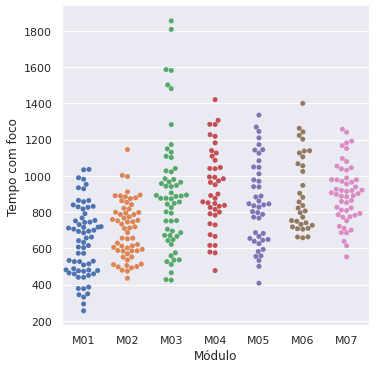

In [127]:
g = sns.catplot(x='modulo', y='media_tempo_foco', data=data, kind='swarm')
g.add_legend()
g.set_axis_labels("Módulo", "Tempo com foco")
g.set_xticklabels(np.sort(trabalhos_praticos.titulo.unique()))
plt.show()

### 8.2 - Lmplots

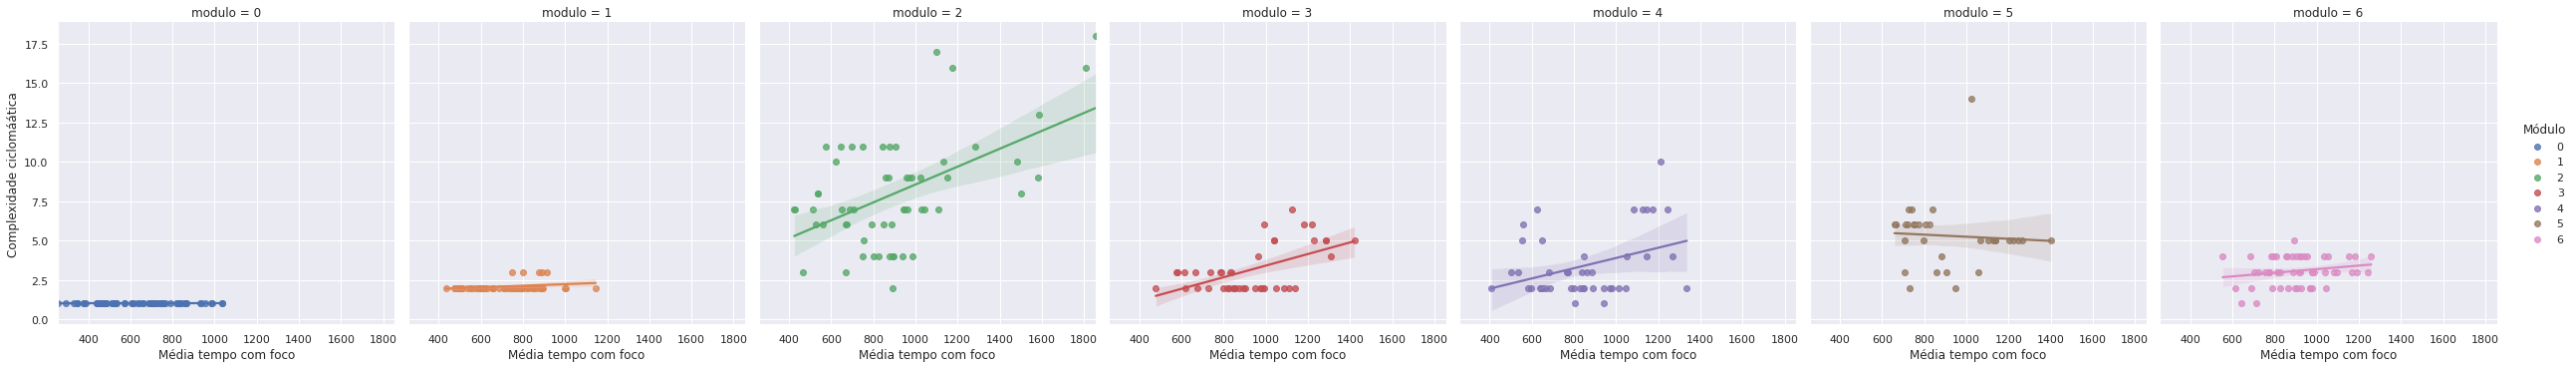

In [128]:
g = sns.lmplot(x='media_tempo_foco', y='complexity', hue='modulo', col='modulo', data=data)
g.add_legend(title='Módulo')
g.set_axis_labels("Média tempo com foco", "Complexidade ciclomáática")

plt.show()

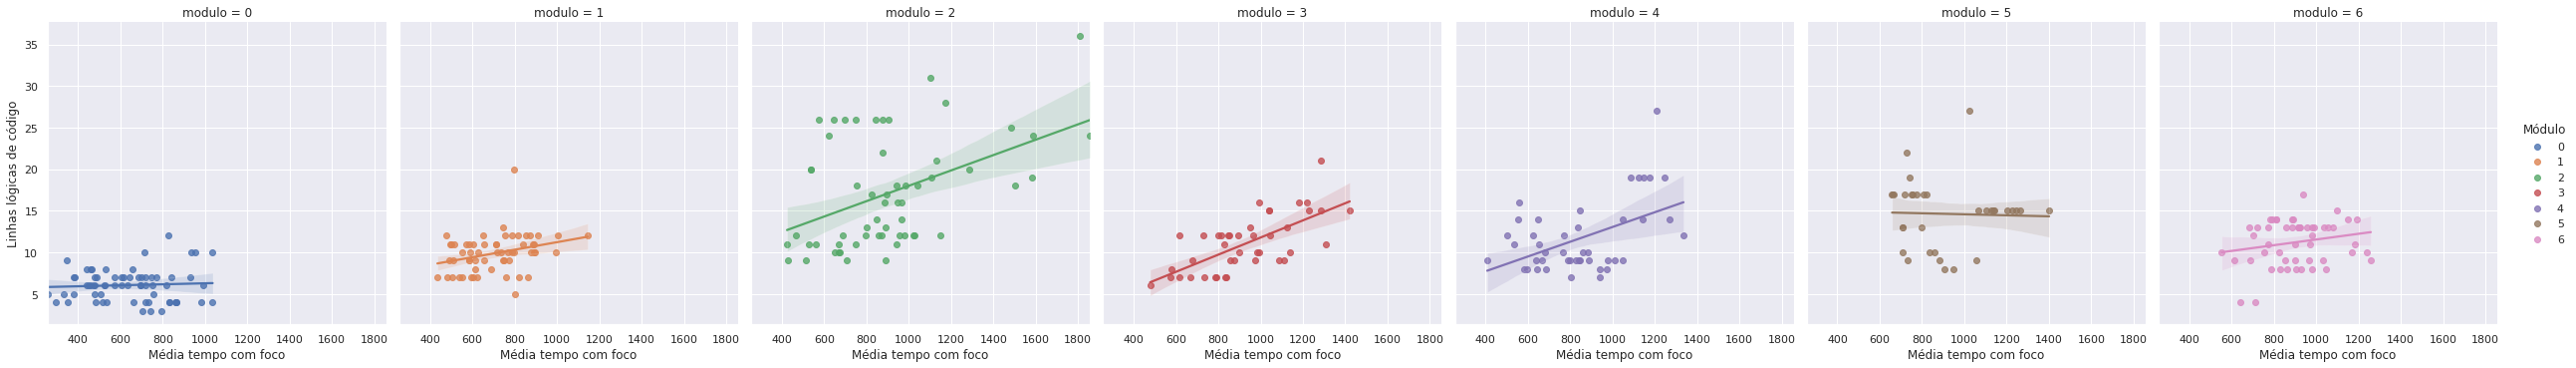

In [129]:
g = sns.lmplot(x='media_tempo_foco', y='lloc', hue='modulo', col='modulo', data=data)
g.add_legend(title='Módulo')
g.set_axis_labels("Média tempo com foco", "Linhas lógicas de código")

plt.show()

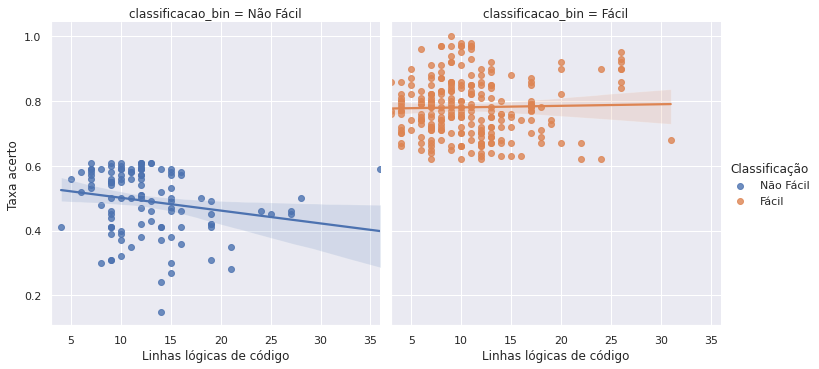

In [130]:
g = sns.lmplot(x='lloc', y='taxa_acerto', hue='classificacao_bin', col='classificacao_bin', data=data)
g.add_legend(title='Classificação')
g.set_axis_labels("Linhas lógicas de código", "Taxa acerto")

plt.show()

### 8.3 - Correlation Heatmap (code metrics)

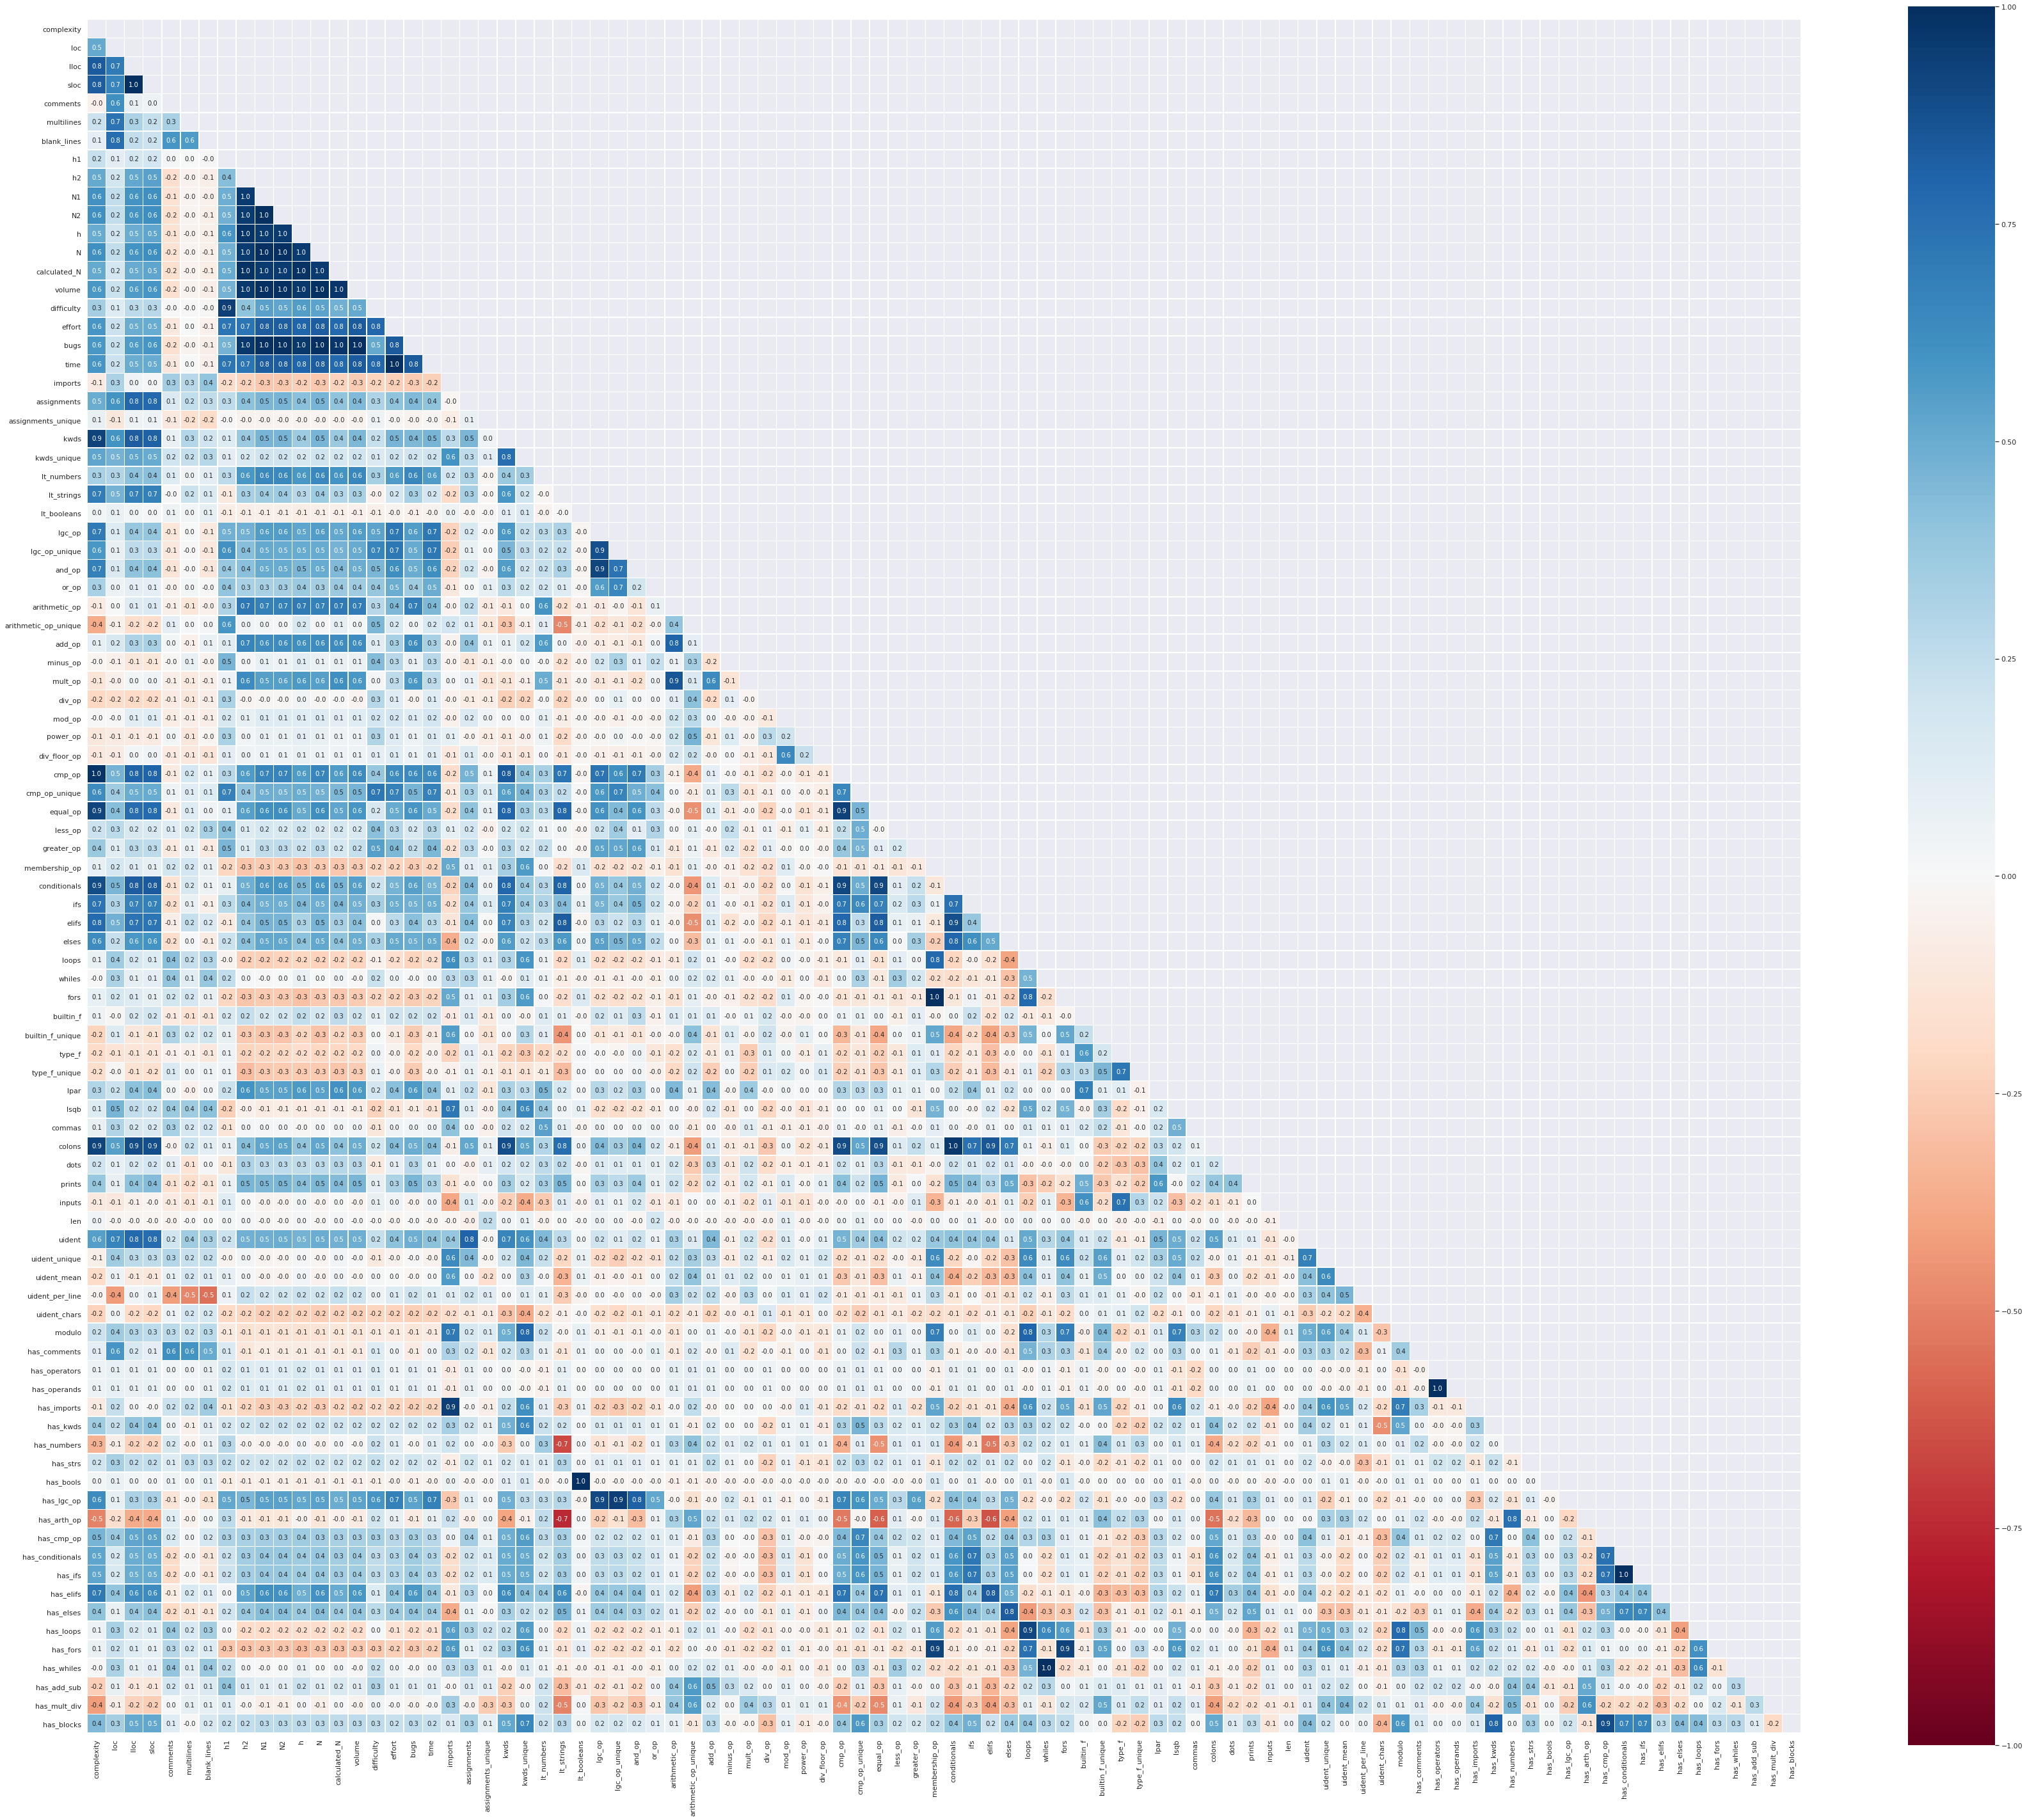

In [131]:
temp = data.loc[:, :'has_blocks']
corr = temp.loc[:, temp.var() > 0.].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(60,50))
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    square=True,
    linewidths=.5,
    cmap='RdBu',
    annot=True,
    fmt=".1f"
)
plt.show()

### 8.4 - Correlation Heatmap (coh metrix)

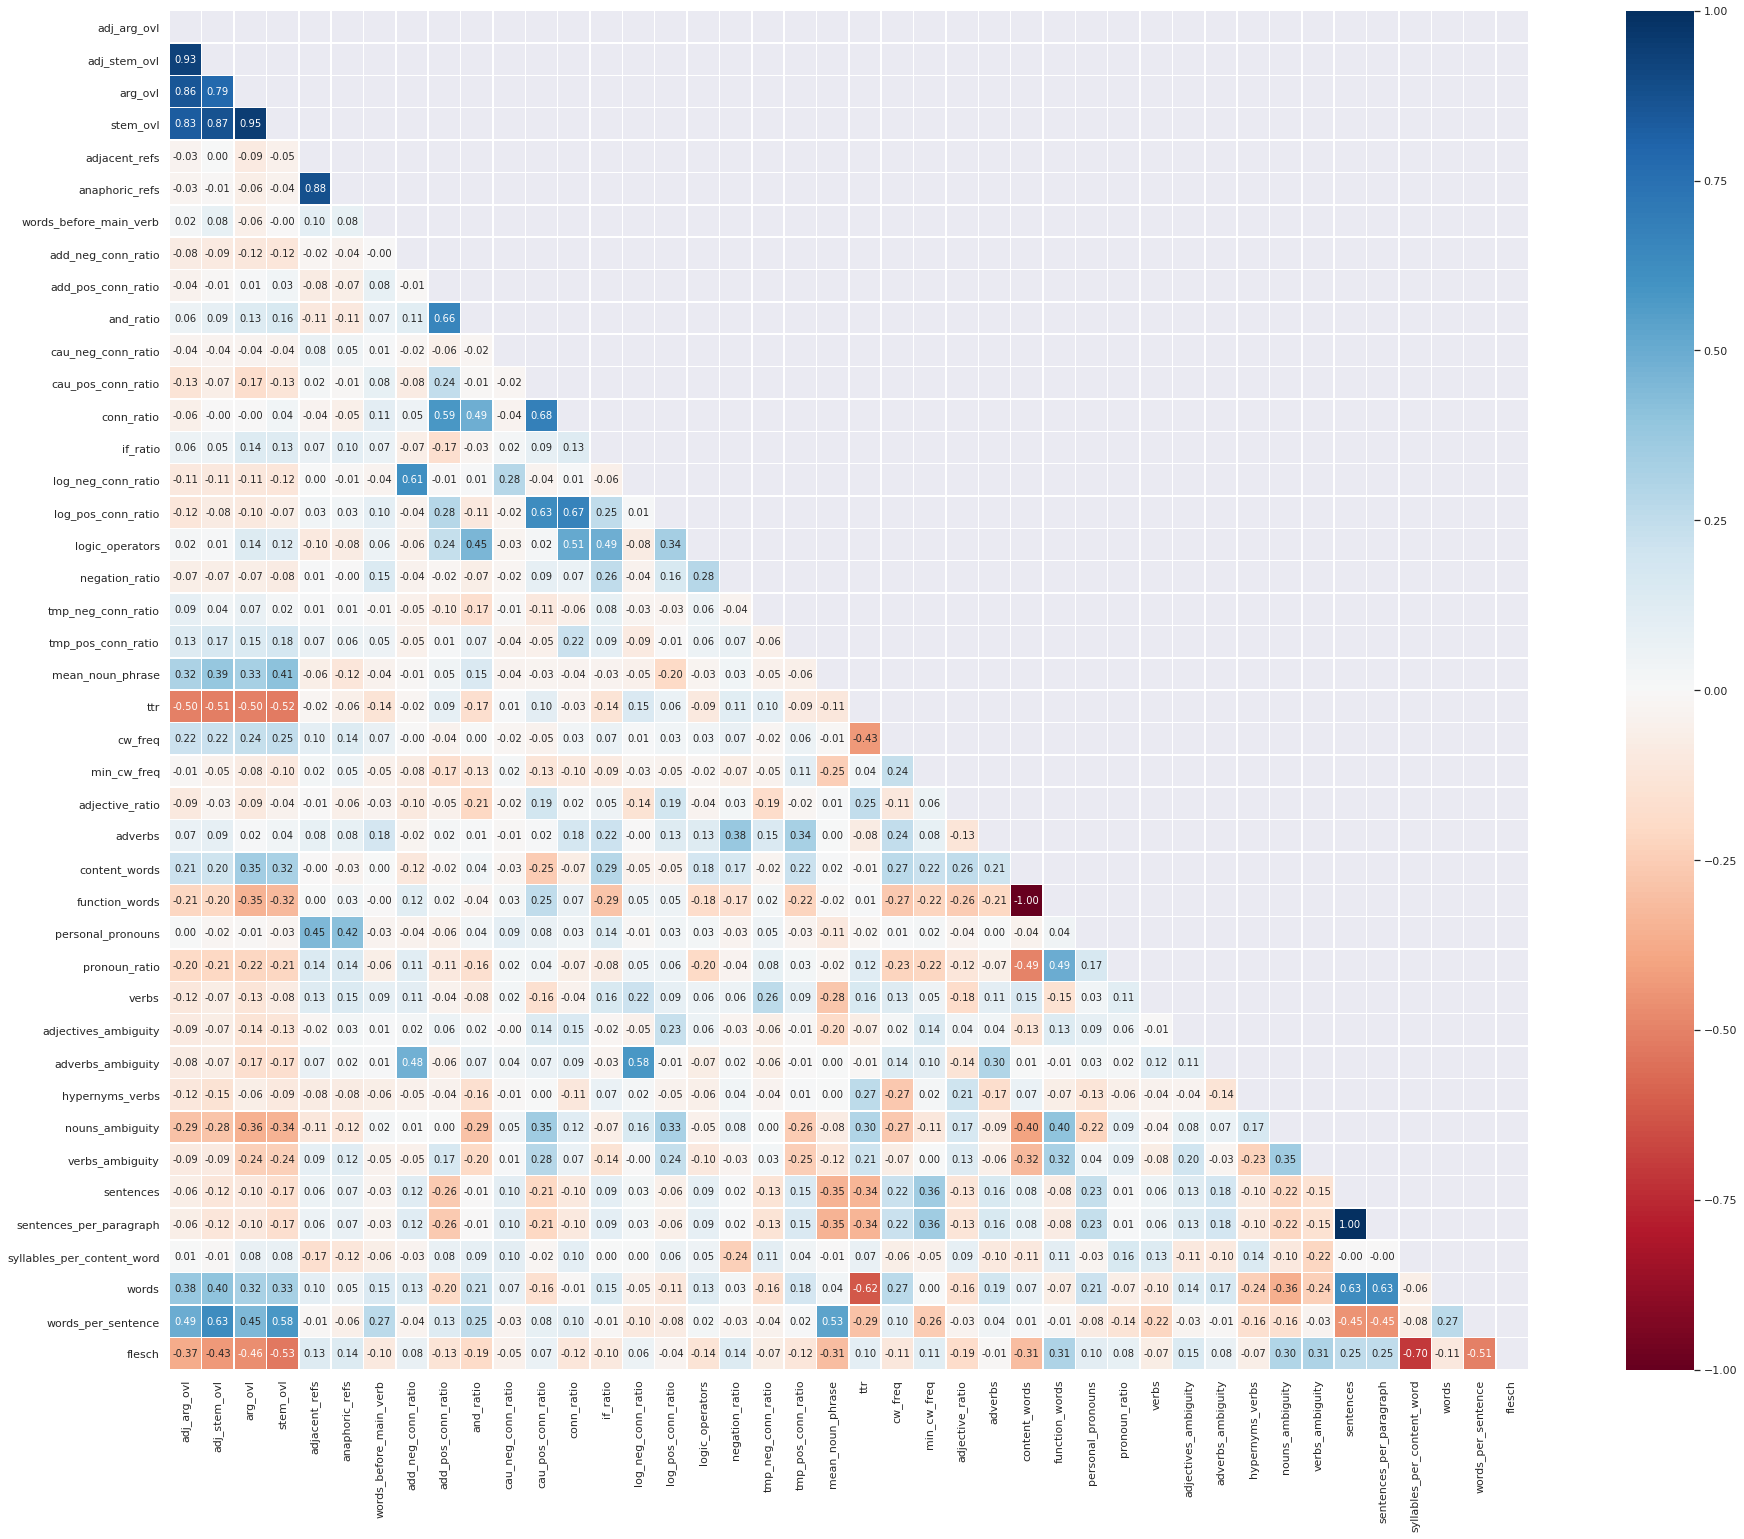

In [132]:
temp = data.loc[:, 'adj_arg_ovl':'flesch']
corr = temp.loc[:, temp.var() > 0.].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(35,25))
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    square=True,
    linewidths=.5,
    cmap='RdBu',
    annot=True,
    fmt=".2f"
)
plt.show()

### 8.5 - Correlation Heatmap (targets)

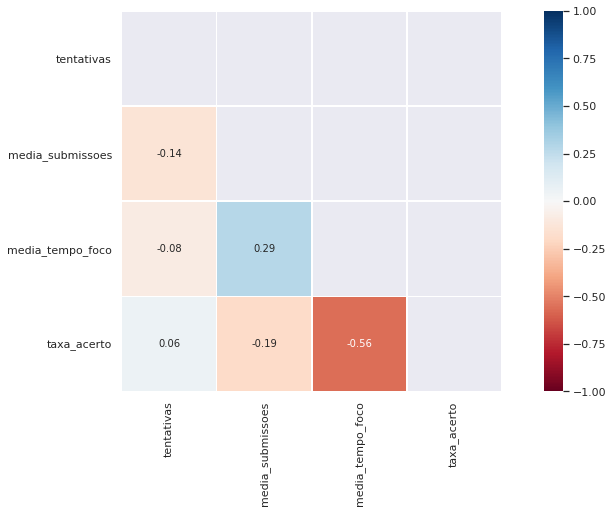

In [133]:
temp = data.loc[:, 'tentativas':'taxa_acerto']
corr = temp.loc[:, temp.var() > 0.].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,7))
ax = sns.heatmap(
    corr,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    square=True,
    linewidths=.5,
    cmap='RdBu',
    annot=True,
    fmt=".2f"
)
plt.show()

### 8.6 - Taxa de acerto médio por Módulo

[Text(0, 0, 'M01'),
 Text(0, 0, 'M02'),
 Text(0, 0, 'M03'),
 Text(0, 0, 'M04'),
 Text(0, 0, 'M05'),
 Text(0, 0, 'M06'),
 Text(0, 0, 'M07')]

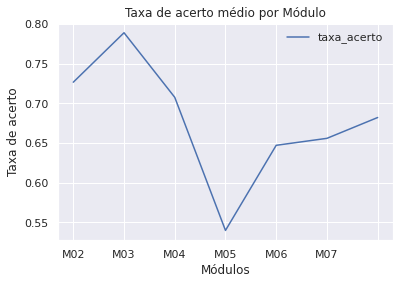

In [134]:
ax = data.groupby(['modulo']).mean()[['taxa_acerto']].plot()
ax.set_title('Taxa de acerto médio por Módulo')
ax.set_xlabel('Módulos')
ax.set_ylabel('Taxa de acerto')
ax.set_xticklabels(np.sort(trabalhos_praticos.titulo.unique()))
#plt.show()

## 10 - Análise de significância

In [135]:
from scipy.stats import ranksums
for m1 in data.modulo.unique():
    for m2 in data.modulo.unique():
        if m1 != m2:
            sample1 = data[data.modulo == m1].taxa_acerto.values
            sample2 = data[data.modulo == m2].taxa_acerto.values
            if ranksums(sample1, sample2).pvalue < .05:
                print(m1, m2, ranksums(sample1, sample2).pvalue)

0 1 0.002393284397722546
0 3 1.0909596461829154e-08
0 5 0.028278088289413587
1 0 0.002393284397722546
1 2 0.004394424751647375
1 6 0.0001630587738815767
1 3 4.181799647978768e-11
1 4 0.0006573707204830191
1 5 1.4578206066448453e-05
2 1 0.004394424751647375
2 3 2.645276302776505e-06
6 1 0.0001630587738815767
6 3 2.020306023440786e-05
3 0 1.0909596461829154e-08
3 1 4.181799647978768e-11
3 2 2.645276302776505e-06
3 6 2.020306023440786e-05
3 4 0.012686647076295849
3 5 0.001966259135400002
4 1 0.0006573707204830191
4 3 0.012686647076295849
5 0 0.028278088289413587
5 1 1.4578206066448453e-05
5 3 0.001966259135400002


## 9 - Salvando os dados

In [136]:
data.isnull().sum().sum()

0

In [137]:
data.to_csv('data.csv', index_label='id')

## Contato

- Marcos A. P. de Lima (marcos.lima@icomp.ufam.edu.br)
- Leandro S. G. de Carvalho (galvao@icomp.ufam.edu.br